In [34]:

import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\tmdbapi실습")  # 원하는 경로로 변경
print(os.getcwd())  # 잘 바뀌었는지 확인


C:\Users\lizzy\스파르타_파이썬\tmdbapi실습


In [7]:
! pip install requests pandas tqdm 



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
! pip install python-dotenv



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import os
from dotenv import load_dotenv

load_dotenv()  # 현재 디렉터리의 .env 파일 읽어서 환경변수로 등록

API_KEY = os.getenv("API_KEY")  # .env에서 API 키 읽어오기

if API_KEY is None:
    raise ValueError("API_KEY가 설정되지 않았습니다. .env 파일에 API_KEY를 확인하세요.")


In [12]:
import requests
import pandas as pd
from tqdm import tqdm
import time

# API_KEY를 여기에 입력하세요

HEADERS = {"accept": "application/json"}

START_DATE = "2023-11-26"
END_DATE = "2023-11-27"


def fetch_discover(endpoint, date_field):
    base_url = f"https://api.themoviedb.org/3/discover/{endpoint}"
    params = {
        "api_key": API_KEY,
        f"{date_field}.gte": START_DATE,
        f"{date_field}.lte": END_DATE,
        "page": 1,
        "include_adult": "true",
        "language": "en-US",
    }
    r = requests.get(base_url, params=params, headers=HEADERS).json()
    total_pages = r.get("total_pages", 1)
    ids = []
    for page in tqdm(range(1, total_pages + 1), desc=f"Fetching {endpoint} IDs"):
        params["page"] = page
        data = requests.get(base_url, params=params, headers=HEADERS).json()
        if "results" in data:
            ids.extend([item["id"] for item in data["results"]])
        time.sleep(0.2)
    return ids


def fetch_reviews(content_type, content_id, max_reviews=3):
    """영화 또는 TV 시리즈의 리뷰 가져오기"""
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "page": 1
    }
    try:
        response = requests.get(url, params=params, headers=HEADERS)
        
        # 디버깅: 상태 코드 확인
        if response.status_code != 200:
            print(f"Review fetch error for {content_type} {content_id}: Status {response.status_code}")
            return ""
        
        data = response.json()
        reviews = data.get("results", [])
        
        if not reviews:
            return ""
        
        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")
        
        return " || ".join(lines)
    
    except Exception as e:
        print(f"Exception fetching reviews for {content_type} {content_id}: {e}")
        return ""


def fetch_movie_details(movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"
    }
    data = requests.get(url, params=params, headers=HEADERS).json()

    collection = data.get("belongs_to_collection")
    collection_name = collection["name"] if collection else None

    record = {
        "id": data.get("id"),
        "type": "movie",
        "adult": data.get("adult"),
        "backdrop_path": data.get("backdrop_path"),
        "belongs_to_collection": collection_name,
        "budget": data.get("budget"),
        "genres": ", ".join([g["name"] for g in data.get("genres", [])]),
        "homepage": data.get("homepage"),
        "imdb_id": data.get("imdb_id"),
        "original_language": data.get("original_language"),
        "original_title": data.get("original_title"),
        "overview": data.get("overview"),
        "popularity": data.get("popularity"),
        "poster_path": data.get("poster_path"),
        "production_companies": ", ".join([c["name"] for c in data.get("production_companies", [])]),
        "production_countries": ", ".join([c["name"] for c in data.get("production_countries", [])]),
        "release_date": data.get("release_date"),
        "revenue": data.get("revenue"),
        "runtime": data.get("runtime"),
        "spoken_languages": ", ".join([l["name"] for l in data.get("spoken_languages", [])]),
        "status": data.get("status"),
        "tagline": data.get("tagline"),
        "title": data.get("title"),
        "video": data.get("video"),
        "vote_average": data.get("vote_average"),
        "vote_count": data.get("vote_count"),
    }

    credits = data.get("credits", {})
    cast = credits.get("cast", [])
    crew = credits.get("crew", [])
    record["top_5_cast"] = ", ".join([c["name"] for c in cast[:5]])
    directors = [c["name"] for c in crew if c.get("job") == "Director"]
    record["directors"] = ", ".join(directors)
    
    # 리뷰 가져오기
    time.sleep(0.25)  # Rate limiting
    record["review"] = fetch_reviews("movie", movie_id)

    return record


def fetch_tv_details(series_id):
    """TV Series 상세"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"
    }
    data = requests.get(url, params=params, headers=HEADERS).json()

    def episode_info_str(ep):
        if not ep:
            return None
        keys = ["id", "name", "overview", "vote_average", "vote_count", "air_date", "episode_number", "season_number", "runtime", "still_path"]
        return ", ".join(f"{k}: {ep.get(k)}" for k in keys if ep.get(k) is not None)

    def simple_list_to_str(lst, key="name"):
        return ", ".join([item.get(key, "") for item in lst]) if lst else ""

    record = {
        "id": data.get("id"),
        "type": "tv_series",
        "adult": data.get("adult"),
        "backdrop_path": data.get("backdrop_path"),
        "created_by": simple_list_to_str(data.get("created_by", [])),
        "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
        "first_air_date": data.get("first_air_date"),
        "genres": simple_list_to_str(data.get("genres", [])),
        "homepage": data.get("homepage"),
        "in_production": data.get("in_production"),
        "languages": ", ".join(data.get("languages", [])),
        "last_air_date": data.get("last_air_date"),
        "last_episode_to_air": episode_info_str(data.get("last_episode_to_air")),
        "name": data.get("name"),
        "next_episode_to_air": episode_info_str(data.get("next_episode_to_air")),
        "networks": simple_list_to_str(data.get("networks", [])),
        "number_of_episodes": data.get("number_of_episodes"),
        "number_of_seasons": data.get("number_of_seasons"),
        "origin_country": ", ".join(data.get("origin_country", [])),
        "original_language": data.get("original_language"),
        "original_name": data.get("original_name"),
        "overview": data.get("overview"),
        "popularity": data.get("popularity"),
        "poster_path": data.get("poster_path"),
        "production_companies": simple_list_to_str(data.get("production_companies", [])),
        "production_countries": simple_list_to_str(data.get("production_countries", [])),
        "seasons": "; ".join([f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)" for s in data.get("seasons", [])]),
        "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
        "status": data.get("status"),
        "tagline": data.get("tagline"),
        "type_detail": data.get("type"),
        "vote_average": data.get("vote_average"),
        "vote_count": data.get("vote_count"),
    }
    
    # 리뷰 가져오기
    time.sleep(0.25)  # Rate limiting
    record["review"] = fetch_reviews("tv", series_id)

    return record


def fetch_tv_season(series_id, season_number):
    """TV Season 상세 정보 및 에피소드 리스트 반환"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}/season/{season_number}"
    params = {"api_key": API_KEY, "language": "en-US"}
    data = requests.get(url, params=params, headers=HEADERS).json()

    def parse_crew_or_guest(lst):
        if not lst:
            return []
        return [
            {
                "id": person.get("id"),
                "name": person.get("name"),
                "original_name": person.get("original_name"),
                "department": person.get("department"),
                "job": person.get("job"),
                "credit_id": person.get("credit_id"),
                "adult": person.get("adult"),
                "gender": person.get("gender"),
                "known_for_department": person.get("known_for_department"),
                "popularity": person.get("popularity"),
                "profile_path": person.get("profile_path"),
                "character": person.get("character") if "character" in person else None,
                "order": person.get("order") if "order" in person else None,
            }
            for person in lst
        ]

    def parse_episode(ep):
        return {
            "id": ep.get("id"),
            "name": ep.get("name"),
            "overview": ep.get("overview"),
            "air_date": ep.get("air_date"),
            "episode_number": ep.get("episode_number"),
            "episode_type": ep.get("episode_type"),
            "production_code": ep.get("production_code"),
            "runtime": ep.get("runtime"),
            "season_number": ep.get("season_number"),
            "show_id": ep.get("show_id"),
            "still_path": ep.get("still_path"),
            "vote_average": ep.get("vote_average"),
            "vote_count": ep.get("vote_count"),
            "crew": parse_crew_or_guest(ep.get("crew", [])),
            "guest_stars": parse_crew_or_guest(ep.get("guest_stars", [])),
        }

    record = {
        "_id": data.get("_id"),
        "id": data.get("id"),
        "series_id": series_id,
        "season_number": data.get("season_number"),
        "name": data.get("name"),
        "overview": data.get("overview"),
        "air_date": data.get("air_date"),
        "poster_path": data.get("poster_path"),
        "vote_average": data.get("vote_average"),
        "networks": [
            {
                "id": net.get("id"),
                "logo_path": net.get("logo_path"),
                "name": net.get("name"),
                "origin_country": net.get("origin_country"),
            }
            for net in data.get("networks", [])
        ],
        "episodes": [parse_episode(ep) for ep in data.get("episodes", [])],
    }

    return record


def fetch_tv_episode(series_id, season_number, episode_number):
    """TV Episode 상세 정보"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}/season/{season_number}/episode/{episode_number}"
    params = {"api_key": API_KEY, "language": "en-US"}
    data = requests.get(url, params=params, headers=HEADERS).json()

    def parse_crew_or_guest(lst):
        if not lst:
            return []
        return [
            {
                "id": person.get("id", 0),
                "name": person.get("name"),
                "original_name": person.get("original_name"),
                "department": person.get("department"),
                "job": person.get("job"),
                "credit_id": person.get("credit_id"),
                "adult": person.get("adult", True),
                "gender": person.get("gender", 0),
                "known_for_department": person.get("known_for_department"),
                "popularity": person.get("popularity", 0.0),
                "profile_path": person.get("profile_path"),
                "character": person.get("character") if "character" in person else None,
                "order": person.get("order") if "order" in person else None,
            }
            for person in lst
        ]

    record = {
        "series_id": series_id,
        "season_number": data.get("season_number", season_number),
        "episode_number": data.get("episode_number", episode_number),
        "id": data.get("id", 0),
        "name": data.get("name"),
        "overview": data.get("overview"),
        "air_date": data.get("air_date"),
        "production_code": data.get("production_code"),
        "runtime": data.get("runtime", 0),
        "still_path": data.get("still_path"),
        "vote_average": data.get("vote_average", 0.0),
        "vote_count": data.get("vote_count", 0),
        "crew": parse_crew_or_guest(data.get("crew", [])),
        "guest_stars": parse_crew_or_guest(data.get("guest_stars", [])),
    }
    return record


# ============================================================
# Main Run
# ============================================================
if __name__ == "__main__":
    print("데이터 수집 시작...")
    
    movie_ids = fetch_discover("movie", "primary_release_date")
    tv_ids = fetch_discover("tv", "first_air_date")

    print(f"영화 {len(movie_ids)}개, TV 시리즈 {len(tv_ids)}개 수집됨")

    movie_records = []
    tv_series_records = []
    tv_season_records = []
    tv_episode_records = []

    # Movie
    for cid in tqdm(movie_ids, desc="Movie Details"):
        try:
            movie_records.append(fetch_movie_details(cid))
            time.sleep(0.25)
        except Exception as e:
            print(f"Movie Error: {cid}, {e}")

    # TV Series + Season + Episode
    for sid in tqdm(tv_ids, desc="TV Series Details"):
        try:
            # TV Series
            tv_series_records.append(fetch_tv_details(sid))
            time.sleep(0.25)

            # Season 반복
            series_detail = tv_series_records[-1]
            num_seasons = series_detail["number_of_seasons"] or 0

            for sn in range(1, num_seasons + 1):
                season_record = fetch_tv_season(sid, sn)
                tv_season_records.append(season_record)

                # Episode 반복
                for ep in season_record["episodes"]:
                    tv_episode_records.append(
                        fetch_tv_episode(sid, sn, ep["episode_number"])
                    )
                    time.sleep(0.15)

                time.sleep(0.15)

        except Exception as e:
            print(f"TV error: {sid}, {e}")

    # CSV 저장
    print("\nCSV 파일 저장 중...")
    pd.DataFrame(movie_records).to_csv("movies.csv", index=False, encoding="utf-8-sig")
    pd.DataFrame(tv_series_records).to_csv("tv_series.csv", index=False, encoding="utf-8-sig")
    pd.DataFrame(tv_season_records).to_csv("tv_seasons.csv", index=False, encoding="utf-8-sig")
    pd.DataFrame(tv_episode_records).to_csv("tv_episodes.csv", index=False, encoding="utf-8-sig")

    print("🎉 모든 CSV 파일 생성 완료!")
    print(f"- 영화: {len(movie_records)}개")
    print(f"- TV 시리즈: {len(tv_series_records)}개")
    print(f"- TV 시즌: {len(tv_season_records)}개")
    print(f"- TV 에피소드: {len(tv_episode_records)}개")

데이터 수집 시작...


Fetching tv IDs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


영화 317개, TV 시리즈 88개 수집됨


TV Series Details:  48%|████████████████████████████████████████████████████████████████████████▌                                                                               | 42/88 [09:11<05:04,  6.62s/it]

TV error: 255377, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/255377/season/3/episode/1?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
TV error: 244025, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/244025?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206660EC690>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
TV error: 234560, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/234560?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206660EE1D

TV Series Details: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [09:11<00:00,  6.27s/it]

TV error: 296855, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/296855?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206660F7850>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
TV error: 278252, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/278252?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206660EC590>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
TV error: 278226, HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/278226?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib

In [19]:
import requests
import pandas as pd
from tqdm import tqdm
import time

HEADERS = {"accept": "application/json"}


def fetch_latest_tv_series(max_items=200):
    """최신 TV 시리즈 ID 가져오기 (최신순 정렬)"""
    base_url = "https://api.themoviedb.org/3/tv/on_the_air"  # 현재 방영 중인 시리즈
    # 또는 "https://api.themoviedb.org/3/tv/popular" 사용 가능
    
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "page": 1,
    }
    
    ids = []
    page = 1
    
    # 최대 10페이지까지 (약 200개 시리즈)
    while len(ids) < max_items and page <= 10:
        params["page"] = page
        try:
            response = requests.get(base_url, params=params, headers=HEADERS, timeout=10)
            data = response.json()
            
            if "results" in data:
                ids.extend([item["id"] for item in data["results"]])
                print(f"페이지 {page}: {len(data['results'])}개 시리즈 발견")
            
            page += 1
            time.sleep(0.3)
            
        except Exception as e:
            print(f"페이지 {page} 가져오기 오류: {e}")
            break
    
    return ids[:max_items]


def fetch_reviews(content_type, content_id, max_reviews=3):
    """영화 또는 TV 시리즈의 리뷰 가져오기"""
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "page": 1
    }
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=10)
        
        if response.status_code != 200:
            return ""
        
        data = response.json()
        reviews = data.get("results", [])
        
        if not reviews:
            return ""
        
        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")
        
        return " || ".join(lines)
    
    except Exception as e:
        return ""


def fetch_tv_details(series_id):
    """TV Series 상세"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"
    }
    data = requests.get(url, params=params, headers=HEADERS, timeout=10).json()

    def episode_info_str(ep):
        if not ep:
            return None
        keys = ["id", "name", "overview", "vote_average", "vote_count", "air_date", "episode_number", "season_number", "runtime", "still_path"]
        return ", ".join(f"{k}: {ep.get(k)}" for k in keys if ep.get(k) is not None)

    def simple_list_to_str(lst, key="name"):
        return ", ".join([item.get(key, "") for item in lst]) if lst else ""

    record = {
        "id": data.get("id"),
        "type": "tv_series",
        "adult": data.get("adult"),
        "backdrop_path": data.get("backdrop_path"),
        "created_by": simple_list_to_str(data.get("created_by", [])),
        "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
        "first_air_date": data.get("first_air_date"),
        "genres": simple_list_to_str(data.get("genres", [])),
        "homepage": data.get("homepage"),
        "in_production": data.get("in_production"),
        "languages": ", ".join(data.get("languages", [])),
        "last_air_date": data.get("last_air_date"),
        "last_episode_to_air": episode_info_str(data.get("last_episode_to_air")),
        "name": data.get("name"),
        "next_episode_to_air": episode_info_str(data.get("next_episode_to_air")),
        "networks": simple_list_to_str(data.get("networks", [])),
        "number_of_episodes": data.get("number_of_episodes"),
        "number_of_seasons": data.get("number_of_seasons"),
        "origin_country": ", ".join(data.get("origin_country", [])),
        "original_language": data.get("original_language"),
        "original_name": data.get("original_name"),
        "overview": data.get("overview"),
        "popularity": data.get("popularity"),
        "poster_path": data.get("poster_path"),
        "production_companies": simple_list_to_str(data.get("production_companies", [])),
        "production_countries": simple_list_to_str(data.get("production_countries", [])),
        "seasons": "; ".join([f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)" for s in data.get("seasons", [])]),
        "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
        "status": data.get("status"),
        "tagline": data.get("tagline"),
        "type_detail": data.get("type"),
        "vote_average": data.get("vote_average"),
        "vote_count": data.get("vote_count"),
    }
    
    # 리뷰 가져오기
    record["review"] = fetch_reviews("tv", series_id)

    return record


# ============================================================
# Main Run
# ============================================================
if __name__ == "__main__":
    print("데이터 수집 시작...")
    print("최신 TV 시리즈 중 리뷰가 있는 20개 수집")
    
    # 최신 TV 시리즈 ID 가져오기
    tv_ids = fetch_latest_tv_series(max_items=200)
    print(f"\n총 {len(tv_ids)}개의 TV 시리즈 발견됨")

    tv_series_records = []
    max_tv_with_reviews = 20

    # TV Series - 리뷰가 있는 TV 시리즈 20개만 수집
    print(f"\n리뷰가 있는 TV 시리즈 {max_tv_with_reviews}개 수집 중...\n")
    
    for sid in tqdm(tv_ids, desc="TV Series Details"):
        # 이미 20개를 수집했으면 중단
        if len(tv_series_records) >= max_tv_with_reviews:
            print(f"\n목표 달성! {max_tv_with_reviews}개 수집 완료")
            break
            
        try:
            tv_detail = fetch_tv_details(sid)
            
            # 리뷰가 있는 TV 시리즈만 추가
            if tv_detail.get("review"):
                tv_series_records.append(tv_detail)
                print(f"✓ 리뷰 있는 TV 시리즈: {tv_detail.get('name')} (총 {len(tv_series_records)}/20개)")
            
            time.sleep(0.3)  # Rate limiting
            
        except Exception as e:
            print(f"✗ TV Series Error: {sid}, {e}")

    # CSV 저장
    print("\n\nCSV 파일 저장 중...")
    if tv_series_records:
        pd.DataFrame(tv_series_records).to_csv("tv_series_with_reviews_latest.csv", index=False, encoding="utf-8-sig")
        print("🎉 CSV 파일 생성 완료!")
        print(f"- 리뷰가 있는 TV 시리즈: {len(tv_series_records)}개")
        print(f"- 파일명: tv_series_with_reviews_latest.csv")
    else:
        print("⚠️ 리뷰가 있는 TV 시리즈를 찾지 못했습니다.")

데이터 수집 시작...
최신 TV 시리즈 중 리뷰가 있는 20개 수집
페이지 1: 20개 시리즈 발견
페이지 2: 20개 시리즈 발견
페이지 3: 20개 시리즈 발견
페이지 4: 20개 시리즈 발견
페이지 5: 20개 시리즈 발견
페이지 6: 20개 시리즈 발견
페이지 7: 20개 시리즈 발견
페이지 8: 20개 시리즈 발견
페이지 9: 20개 시리즈 발견
페이지 10: 20개 시리즈 발견

총 200개의 TV 시리즈 발견됨

리뷰가 있는 TV 시리즈 20개 수집 중...



TV Series Details:   0%|                                                                                                                                                                | 0/200 [00:00<?, ?it/s]

✓ 리뷰 있는 TV 시리즈: Stranger Things (총 1/20개)


TV Series Details:   0%|▊                                                                                                                                                       | 1/200 [00:02<07:38,  2.31s/it]

✓ 리뷰 있는 TV 시리즈: IT: Welcome to Derry (총 2/20개)


TV Series Details:   1%|█▌                                                                                                                                                      | 2/200 [00:04<07:36,  2.30s/it]

✓ 리뷰 있는 TV 시리즈: The Simpsons (총 3/20개)


TV Series Details:   2%|██▎                                                                                                                                                     | 3/200 [00:06<07:39,  2.33s/it]

✓ 리뷰 있는 TV 시리즈: NCIS (총 4/20개)


TV Series Details:   5%|███████▌                                                                                                                                               | 10/200 [00:23<07:19,  2.31s/it]

✓ 리뷰 있는 TV 시리즈: One-Punch Man (총 5/20개)


TV Series Details:   6%|█████████                                                                                                                                              | 12/200 [00:27<07:15,  2.32s/it]

✓ 리뷰 있는 TV 시리즈: Robin Hood (총 6/20개)


TV Series Details:   6%|█████████▊                                                                                                                                             | 13/200 [00:30<07:16,  2.33s/it]

✓ 리뷰 있는 TV 시리즈: Landman (총 7/20개)


TV Series Details:   8%|███████████▎                                                                                                                                           | 15/200 [00:34<07:10,  2.32s/it]

✓ 리뷰 있는 TV 시리즈: Late Night with Seth Meyers (총 8/20개)


TV Series Details:   8%|████████████                                                                                                                                           | 16/200 [00:37<07:02,  2.30s/it]

✓ 리뷰 있는 TV 시리즈: South Park (총 9/20개)


TV Series Details:  10%|███████████████▊                                                                                                                                       | 21/200 [00:48<06:39,  2.23s/it]

✓ 리뷰 있는 TV 시리즈: Campfire Cooking in Another World with My Absurd Skill (총 10/20개)


TV Series Details:  11%|████████████████▌                                                                                                                                      | 22/200 [00:50<06:35,  2.22s/it]

✓ 리뷰 있는 TV 시리즈: SPY x FAMILY (총 11/20개)


TV Series Details:  14%|████████████████████▍                                                                                                                                  | 27/200 [01:01<06:29,  2.25s/it]

✓ 리뷰 있는 TV 시리즈: Smiling Friends (총 12/20개)


TV Series Details:  14%|█████████████████████▉                                                                                                                                 | 29/200 [01:06<06:25,  2.25s/it]

✓ 리뷰 있는 TV 시리즈: The Graham Norton Show (총 13/20개)


TV Series Details:  16%|███████████████████████▍                                                                                                                               | 31/200 [01:10<06:14,  2.22s/it]

✓ 리뷰 있는 TV 시리즈: Tracker (총 14/20개)


TV Series Details:  18%|██████████████████████████▍                                                                                                                            | 35/200 [01:19<06:05,  2.22s/it]

✓ 리뷰 있는 TV 시리즈: Taxi Driver (총 15/20개)


TV Series Details:  19%|████████████████████████████▋                                                                                                                          | 38/200 [01:26<05:55,  2.20s/it]

✓ 리뷰 있는 TV 시리즈: Coronation Street (총 16/20개)


TV Series Details:  20%|█████████████████████████████▍                                                                                                                         | 39/200 [01:28<05:52,  2.19s/it]

✓ 리뷰 있는 TV 시리즈: One Piece (총 17/20개)


TV Series Details:  20%|██████████████████████████████▉                                                                                                                        | 41/200 [01:32<05:46,  2.18s/it]

✓ 리뷰 있는 TV 시리즈: Murdoch Mysteries (총 18/20개)


TV Series Details:  34%|████████████████████████████████████████████████████                                                                                                   | 69/200 [02:37<04:50,  2.22s/it]

✓ 리뷰 있는 TV 시리즈: Chiikawa (총 19/20개)


TV Series Details:  35%|████████████████████████████████████████████████████▊                                                                                                  | 70/200 [02:39<04:48,  2.22s/it]

✓ 리뷰 있는 TV 시리즈: Adventure Time: Fionna & Cake (총 20/20개)


TV Series Details:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 71/200 [02:41<04:53,  2.28s/it]


목표 달성! 20개 수집 완료


CSV 파일 저장 중...
🎉 CSV 파일 생성 완료!
- 리뷰가 있는 TV 시리즈: 20개
- 파일명: tv_series_with_reviews_latest.csv


In [31]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime

HEADERS = {"accept": "application/json"}


def fetch_tv_series_by_year(year, max_pages=50):
    """특정 연도에 방영된 TV 시리즈 가져오기"""
    base_url = "https://api.themoviedb.org/3/discover/tv"
    
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": f"{year}-01-01",
        "first_air_date.lte": f"{year}-12-31",
        "page": 1,
    }
    
    all_series = []
    
    for page in range(1, max_pages + 1):
        params["page"] = page
        try:
            response = requests.get(base_url, params=params, headers=HEADERS, timeout=10)
            data = response.json()
            
            if "results" in data and data["results"]:
                all_series.extend(data["results"])
                print(f"{year}년 페이지 {page}: {len(data['results'])}개 발견")
            else:
                break
            
            time.sleep(0.3)
            
        except Exception as e:
            print(f"페이지 {page} 가져오기 오류: {e}")
            break
    
    return all_series


def fetch_reviews(content_type, content_id, max_reviews=3):
    """영화 또는 TV 시리즈의 리뷰 가져오기"""
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "page": 1
    }
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=10)
        
        if response.status_code != 200:
            return ""
        
        data = response.json()
        reviews = data.get("results", [])
        
        if not reviews:
            return ""
        
        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")
        
        return " || ".join(lines)
    
    except Exception as e:
        return ""


def fetch_tv_details(series_id):
    """TV Series 상세 정보 가져오기"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"
    }
    
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        def episode_info_str(ep):
            if not ep:
                return None
            keys = ["id", "name", "overview", "vote_average", "vote_count", "air_date", 
                    "episode_number", "season_number", "runtime", "still_path"]
            return ", ".join(f"{k}: {ep.get(k)}" for k in keys if ep.get(k) is not None)

        def simple_list_to_str(lst, key="name"):
            return ", ".join([item.get(key, "") for item in lst]) if lst else ""

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),
            "last_episode_to_air": episode_info_str(data.get("last_episode_to_air")),
            "name": data.get("name"),
            "next_episode_to_air": episode_info_str(data.get("next_episode_to_air")),
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join([f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)" 
                                 for s in data.get("seasons", [])]),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }
        
        # 리뷰 가져오기
        record["review"] = fetch_reviews("tv", series_id)

        return record
    
    except Exception as e:
        print(f"Error fetching details for series {series_id}: {e}")
        return None


# ============================================================
# Main Run
# ============================================================
if __name__ == "__main__":
    print("=" * 60)
    print("2023-2024년 TV 시리즈 인기 TOP 5 수집 시작")
    print("=" * 60)
    
    years = [2023, 2024]
    all_records = []
    
    for year in years:
        print(f"\n\n{'=' * 60}")
        print(f"{year}년 TV 시리즈 수집 중...")
        print(f"{'=' * 60}\n")
        
        # 해당 연도 TV 시리즈 가져오기
        tv_series = fetch_tv_series_by_year(year, max_pages=10)
        print(f"\n{year}년 총 {len(tv_series)}개 시리즈 발견")
        
        # popularity 기준 정렬 (이미 정렬되어 있지만 확실하게)
        tv_series_sorted = sorted(tv_series, key=lambda x: x.get("popularity", 0), reverse=True)
        
        # 상위 5개만 선택
        top5 = tv_series_sorted[:5]
        
        print(f"\n{year}년 TOP 5:")
        for idx, series in enumerate(top5, 1):
            print(f"  {idx}. {series.get('name')} (인기도: {series.get('popularity', 0):.1f})")
        
        # 상세 정보 가져오기
        print(f"\n{year}년 TOP 5 상세 정보 수집 중...\n")
        for series in tqdm(top5, desc=f"{year}년 TOP 5"):
            try:
                detail = fetch_tv_details(series["id"])
                if detail:
                    detail["year"] = year  # 연도 컬럼 추가
                    all_records.append(detail)
                time.sleep(0.3)
            except Exception as e:
                print(f"✗ Error: {series.get('name')}, {e}")
    
    # CSV 저장
    print("\n\n" + "=" * 60)
    print("CSV 파일 저장 중...")
    print("=" * 60)
    
    if all_records:
        df = pd.DataFrame(all_records)
        
        # 연도별로 정렬
        df = df.sort_values(['year', 'popularity'], ascending=[True, False])
        
        filename = "tv_series_top5_2023_2024.csv"
        df.to_csv(filename, index=False, encoding="utf-8-sig")
        
        print("\n🎉 CSV 파일 생성 완료!")
        print(f"- 총 수집된 TV 시리즈: {len(all_records)}개")
        print(f"  * 2023년: {len([r for r in all_records if r['year'] == 2023])}개")
        print(f"  * 2024년: {len([r for r in all_records if r['year'] == 2024])}개")
        print(f"- 파일명: {filename}")
        
        # 리뷰 통계
        with_reviews = len([r for r in all_records if r.get('review')])
        print(f"- 리뷰 포함: {with_reviews}개 / {len(all_records)}개")
        
        print("\n연도별 TOP 5:")
        for year in years:
            print(f"\n{year}년:")
            year_records = [r for r in all_records if r['year'] == year]
            for idx, record in enumerate(year_records, 1):
                print(f"  {idx}. {record['name']} (인기도: {record['popularity']:.1f})")
                
    else:
        print("⚠️ 수집된 데이터가 없습니다.")
    
    print("\n" + "=" * 60)
    print("작업 완료!")
    print("=" * 60)

2023-2024년 TV 시리즈 인기 TOP 5 수집 시작


2023년 TV 시리즈 수집 중...

2023년 페이지 1: 20개 발견
2023년 페이지 2: 20개 발견
2023년 페이지 3: 20개 발견
2023년 페이지 4: 20개 발견
2023년 페이지 5: 20개 발견
2023년 페이지 6: 20개 발견
2023년 페이지 7: 20개 발견
2023년 페이지 8: 20개 발견
2023년 페이지 9: 20개 발견
2023년 페이지 10: 20개 발견

2023년 총 200개 시리즈 발견

2023년 TOP 5:
  1. Campfire Cooking in Another World with My Absurd Skill (인기도: 57.2)
  2. Boundless Love (인기도: 41.2)
  3. Silo (인기도: 28.6)
  4. The Apothecary Diaries (인기도: 27.3)
  5. Gen V (인기도: 27.0)

2023년 TOP 5 상세 정보 수집 중...



2023년 TOP 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]




2024년 TV 시리즈 수집 중...

2024년 페이지 1: 20개 발견
2024년 페이지 2: 20개 발견
2024년 페이지 3: 20개 발견
2024년 페이지 4: 20개 발견
2024년 페이지 5: 20개 발견
2024년 페이지 6: 20개 발견
2024년 페이지 7: 20개 발견
2024년 페이지 8: 20개 발견
2024년 페이지 9: 20개 발견
2024년 페이지 10: 20개 발견

2024년 총 200개 시리즈 발견

2024년 TOP 5:
  1. Hazbin Hotel (인기도: 103.7)
  2. Mahsun J (인기도: 66.6)
  3. Maxton Hall - The World Between Us (인기도: 65.7)
  4. Landman (인기도: 53.6)
  5. Mehmed: Sultan of Conquests (인기도: 43.8)

2024년 TOP 5 상세 정보 수집 중...



2024년 TOP 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]



CSV 파일 저장 중...

🎉 CSV 파일 생성 완료!
- 총 수집된 TV 시리즈: 10개
  * 2023년: 5개
  * 2024년: 5개
- 파일명: tv_series_top5_2023_2024.csv
- 리뷰 포함: 5개 / 10개

연도별 TOP 5:

2023년:
  1. Campfire Cooking in Another World with My Absurd Skill (인기도: 57.2)
  2. Boundless Love (인기도: 41.2)
  3. Silo (인기도: 28.6)
  4. The Apothecary Diaries (인기도: 27.3)
  5. Gen V (인기도: 27.0)

2024년:
  1. Hazbin Hotel (인기도: 103.7)
  2. Mahsun J (인기도: 66.6)
  3. Maxton Hall - The World Between Us (인기도: 65.7)
  4. Landman (인기도: 53.6)
  5. Mehmed: Sultan of Conquests (인기도: 43.8)

작업 완료!


In [36]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

HEADERS = {"accept": "application/json"}



def fetch_tv_series_by_year(year, max_items=500):
    """특정 연도에 방영된 TV 시리즈 가져오기 (최대 max_items개)"""
    base_url = "https://api.themoviedb.org/3/discover/tv"

    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": f"{year}-01-01",
        "first_air_date.lte": f"{year}-12-31",
        "page": 1,
    }

    all_series = []
    page = 1

    while len(all_series) < max_items and page <= 25:
        params["page"] = page
        try:
            response = requests.get(base_url, params=params, headers=HEADERS, timeout=10)
            data = response.json()

            if "results" in data and data["results"]:
                all_series.extend(data["results"])
                print(f"{year}년 페이지 {page}: {len(data['results'])}개 발견 (누적: {len(all_series)}개)")
            else:
                break

            page += 1
            time.sleep(0.2)

        except Exception as e:
            print(f"페이지 {page} 가져오기 오류: {e}")
            break

    return all_series[:max_items]


def fetch_reviews(content_type, content_id, max_reviews=3):
    """영화 또는 TV 시리즈의 리뷰 가져오기"""
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "page": 1
    }
    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=10)

        if response.status_code != 200:
            return ""

        data = response.json()
        reviews = data.get("results", [])

        if not reviews:
            return ""

        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")

        return " || ".join(lines)

    except:
        return ""


def fetch_tv_details(series_id):
    """TV Series 상세 정보 가져오기"""
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"
    }

    try:
        response = requests.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        def episode_info_str(ep):
            if not ep:
                return None
            keys = ["id", "name", "overview", "vote_average", "vote_count", "air_date",
                    "episode_number", "season_number", "runtime", "still_path"]
            return ", ".join(f"{k}: {ep.get(k)}" for k in keys if ep.get(k) is not None)

        def simple_list_to_str(lst, key="name"):
            return ", ".join([item.get(key, "") for item in lst]) if lst else ""

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),
            "last_episode_to_air": episode_info_str(data.get("last_episode_to_air")),
            "name": data.get("name"),
            "next_episode_to_air": episode_info_str(data.get("next_episode_to_air")),
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join(
                f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)"
                for s in data.get("seasons", [])
            ),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }

        record["review"] = fetch_reviews("tv", series_id)

        return record

    except Exception as e:
        print(f"Error fetching details for {series_id}: {e}")
        return None


# ============================================================
# 멀티스레드 적용된 MAIN
# ============================================================

if __name__ == "__main__":
    print("=" * 80)
    print("🔥 멀티스레드 버전: 2005~2025 TV Series 수집 시작")
    print("=" * 80)

    years = list(range(2005, 2026))
    all_records = []

    total_start = time.time()

    for year in years:
        print(f"\n\n{'=' * 80}")
        print(f"📅 {year}년 TV 시리즈 수집 시작")
        print("=" * 80)

        # -----------------------------
        # 1) 연도별 TOP 500 목록 수집
        # -----------------------------
        tv_series = fetch_tv_series_by_year(year, max_items=500)

        if not tv_series:
            print(f"⚠️ {year}년 데이터 없음. continue")
            continue

        tv_series_sorted = sorted(tv_series, key=lambda x: x.get("popularity", 0), reverse=True)
        top500 = tv_series_sorted[:500]

        print(f"{year}년 TV 시리즈 {len(top500)}개 상세 정보 수집 시작...\n")

        # -----------------------------
        # 2) 멀티스레드로 상세 정보 Fetch
        # -----------------------------
        results = []
        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = {executor.submit(fetch_tv_details, s["id"]): s for s in top500}

            for future in tqdm(as_completed(futures), total=len(futures), desc=f"{year} 상세 수집"):
                detail = future.result()
                if detail:
                    detail["year"] = year
                    results.append(detail)

        print(f"✓ {year}년 완료: {len(results)}개")

        all_records.extend(results)

        # 중간 저장
        if year % 5 == 0:
            temp = f"tv_series_temp_until_{year}.csv"
            pd.DataFrame(all_records).to_csv(temp, index=False, encoding="utf-8-sig")
            print(f"💾 중간 저장 완료 → {temp}")


    # -----------------------------
    # 최종 저장
    # -----------------------------
    if all_records:
        df = pd.DataFrame(all_records)
        df = df.sort_values(["year", "popularity"], ascending=[True, False])
        df.to_csv("tv_series_top500_2005_2025_multithread.csv", index=False, encoding="utf-8-sig")

        elapsed = time.time() - total_start
        print("\n🎉 전체 완료!")
        print(f"- 총 {len(all_records):,}개")
        print(f"- 소요시간: {elapsed/3600:.2f} 시간")
        print("- 파일명: tv_series_top500_2005_2025_multithread.csv")

    else:
        print("⚠️ No records found")


🔥 멀티스레드 버전: 2005~2025 TV Series 수집 시작


📅 2005년 TV 시리즈 수집 시작
2005년 페이지 1: 20개 발견 (누적: 20개)
2005년 페이지 2: 20개 발견 (누적: 40개)
2005년 페이지 3: 20개 발견 (누적: 60개)
2005년 페이지 4: 20개 발견 (누적: 80개)
2005년 페이지 5: 20개 발견 (누적: 100개)
2005년 페이지 6: 20개 발견 (누적: 120개)
2005년 페이지 7: 20개 발견 (누적: 140개)
2005년 페이지 8: 20개 발견 (누적: 160개)
2005년 페이지 9: 20개 발견 (누적: 180개)
2005년 페이지 10: 20개 발견 (누적: 200개)
2005년 페이지 11: 20개 발견 (누적: 220개)
2005년 페이지 12: 20개 발견 (누적: 240개)
2005년 페이지 13: 20개 발견 (누적: 260개)
2005년 페이지 14: 20개 발견 (누적: 280개)
2005년 페이지 15: 20개 발견 (누적: 300개)
2005년 페이지 16: 20개 발견 (누적: 320개)
2005년 페이지 17: 20개 발견 (누적: 340개)
2005년 페이지 18: 20개 발견 (누적: 360개)
2005년 페이지 19: 20개 발견 (누적: 380개)
2005년 페이지 20: 20개 발견 (누적: 400개)
2005년 페이지 21: 20개 발견 (누적: 420개)
2005년 페이지 22: 20개 발견 (누적: 440개)
2005년 페이지 23: 20개 발견 (누적: 460개)
2005년 페이지 24: 20개 발견 (누적: 480개)
2005년 페이지 25: 20개 발견 (누적: 500개)
2005년 TV 시리즈 500개 상세 정보 수집 시작...



2005 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:30<00:00,  3.33it/s]


✓ 2005년 완료: 500개
💾 중간 저장 완료 → tv_series_temp_until_2005.csv


📅 2006년 TV 시리즈 수집 시작
2006년 페이지 1: 20개 발견 (누적: 20개)
2006년 페이지 2: 20개 발견 (누적: 40개)
2006년 페이지 3: 20개 발견 (누적: 60개)
2006년 페이지 4: 20개 발견 (누적: 80개)
2006년 페이지 5: 20개 발견 (누적: 100개)
2006년 페이지 6: 20개 발견 (누적: 120개)
2006년 페이지 7: 20개 발견 (누적: 140개)
2006년 페이지 8: 20개 발견 (누적: 160개)
2006년 페이지 9: 20개 발견 (누적: 180개)
2006년 페이지 10: 20개 발견 (누적: 200개)
2006년 페이지 11: 20개 발견 (누적: 220개)
2006년 페이지 12: 20개 발견 (누적: 240개)
2006년 페이지 13: 20개 발견 (누적: 260개)
2006년 페이지 14: 20개 발견 (누적: 280개)
2006년 페이지 15: 20개 발견 (누적: 300개)
2006년 페이지 16: 20개 발견 (누적: 320개)
2006년 페이지 17: 20개 발견 (누적: 340개)
2006년 페이지 18: 20개 발견 (누적: 360개)
2006년 페이지 19: 20개 발견 (누적: 380개)
2006년 페이지 20: 20개 발견 (누적: 400개)
2006년 페이지 21: 20개 발견 (누적: 420개)
2006년 페이지 22: 20개 발견 (누적: 440개)
2006년 페이지 23: 20개 발견 (누적: 460개)
2006년 페이지 24: 20개 발견 (누적: 480개)
2006년 페이지 25: 20개 발견 (누적: 500개)
2006년 TV 시리즈 500개 상세 정보 수집 시작...



2006 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:54<00:00,  2.87it/s]


✓ 2006년 완료: 500개


📅 2007년 TV 시리즈 수집 시작
2007년 페이지 1: 20개 발견 (누적: 20개)
2007년 페이지 2: 20개 발견 (누적: 40개)
2007년 페이지 3: 20개 발견 (누적: 60개)
2007년 페이지 4: 20개 발견 (누적: 80개)
2007년 페이지 5: 20개 발견 (누적: 100개)
2007년 페이지 6: 20개 발견 (누적: 120개)
2007년 페이지 7: 20개 발견 (누적: 140개)
2007년 페이지 8: 20개 발견 (누적: 160개)
2007년 페이지 9: 20개 발견 (누적: 180개)
2007년 페이지 10: 20개 발견 (누적: 200개)
2007년 페이지 11: 20개 발견 (누적: 220개)
2007년 페이지 12: 20개 발견 (누적: 240개)
2007년 페이지 13: 20개 발견 (누적: 260개)
2007년 페이지 14: 20개 발견 (누적: 280개)
2007년 페이지 15: 20개 발견 (누적: 300개)
2007년 페이지 16: 20개 발견 (누적: 320개)
2007년 페이지 17: 20개 발견 (누적: 340개)
2007년 페이지 18: 20개 발견 (누적: 360개)
2007년 페이지 19: 20개 발견 (누적: 380개)
2007년 페이지 20: 20개 발견 (누적: 400개)
2007년 페이지 21: 20개 발견 (누적: 420개)
2007년 페이지 22: 20개 발견 (누적: 440개)
2007년 페이지 23: 20개 발견 (누적: 460개)
2007년 페이지 24: 20개 발견 (누적: 480개)
2007년 페이지 25: 20개 발견 (누적: 500개)
2007년 TV 시리즈 500개 상세 정보 수집 시작...



2007 상세 수집:  15%|██████████████████████▍                                                                                                                                   | 73/500 [00:24<02:24,  2.96it/s]

Error fetching details for 123069: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/123069?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


2007 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:43<00:00,  3.06it/s]


✓ 2007년 완료: 499개


📅 2008년 TV 시리즈 수집 시작
2008년 페이지 1: 20개 발견 (누적: 20개)
2008년 페이지 2: 20개 발견 (누적: 40개)
2008년 페이지 3: 20개 발견 (누적: 60개)
2008년 페이지 4: 20개 발견 (누적: 80개)
2008년 페이지 5: 20개 발견 (누적: 100개)
2008년 페이지 6: 20개 발견 (누적: 120개)
2008년 페이지 7: 20개 발견 (누적: 140개)
2008년 페이지 8: 20개 발견 (누적: 160개)
2008년 페이지 9: 20개 발견 (누적: 180개)
2008년 페이지 10: 20개 발견 (누적: 200개)
2008년 페이지 11: 20개 발견 (누적: 220개)
2008년 페이지 12: 20개 발견 (누적: 240개)
2008년 페이지 13: 20개 발견 (누적: 260개)
2008년 페이지 14: 20개 발견 (누적: 280개)
2008년 페이지 15: 20개 발견 (누적: 300개)
2008년 페이지 16: 20개 발견 (누적: 320개)
2008년 페이지 17: 20개 발견 (누적: 340개)
2008년 페이지 18: 20개 발견 (누적: 360개)
2008년 페이지 19: 20개 발견 (누적: 380개)
2008년 페이지 20: 20개 발견 (누적: 400개)
2008년 페이지 21: 20개 발견 (누적: 420개)
2008년 페이지 22: 20개 발견 (누적: 440개)
2008년 페이지 23: 20개 발견 (누적: 460개)
2008년 페이지 24: 20개 발견 (누적: 480개)
2008년 페이지 25: 20개 발견 (누적: 500개)
2008년 TV 시리즈 500개 상세 정보 수집 시작...



2008 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:51<00:00,  2.92it/s]


✓ 2008년 완료: 500개


📅 2009년 TV 시리즈 수집 시작
2009년 페이지 1: 20개 발견 (누적: 20개)
2009년 페이지 2: 20개 발견 (누적: 40개)
2009년 페이지 3: 20개 발견 (누적: 60개)
2009년 페이지 4: 20개 발견 (누적: 80개)
2009년 페이지 5: 20개 발견 (누적: 100개)
2009년 페이지 6: 20개 발견 (누적: 120개)
2009년 페이지 7: 20개 발견 (누적: 140개)
2009년 페이지 8: 20개 발견 (누적: 160개)
2009년 페이지 9: 20개 발견 (누적: 180개)
2009년 페이지 10: 20개 발견 (누적: 200개)
2009년 페이지 11: 20개 발견 (누적: 220개)
2009년 페이지 12: 20개 발견 (누적: 240개)
2009년 페이지 13: 20개 발견 (누적: 260개)
2009년 페이지 14: 20개 발견 (누적: 280개)
2009년 페이지 15: 20개 발견 (누적: 300개)
2009년 페이지 16: 20개 발견 (누적: 320개)
2009년 페이지 17: 20개 발견 (누적: 340개)
2009년 페이지 18: 20개 발견 (누적: 360개)
2009년 페이지 19: 20개 발견 (누적: 380개)
2009년 페이지 20: 20개 발견 (누적: 400개)
2009년 페이지 21: 20개 발견 (누적: 420개)
2009년 페이지 22: 20개 발견 (누적: 440개)
2009년 페이지 23: 20개 발견 (누적: 460개)
2009년 페이지 24: 20개 발견 (누적: 480개)
2009년 페이지 25: 20개 발견 (누적: 500개)
2009년 TV 시리즈 500개 상세 정보 수집 시작...



2009 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:46<00:00,  3.01it/s]


✓ 2009년 완료: 500개


📅 2010년 TV 시리즈 수집 시작
2010년 페이지 1: 20개 발견 (누적: 20개)
2010년 페이지 2: 20개 발견 (누적: 40개)
2010년 페이지 3: 20개 발견 (누적: 60개)
2010년 페이지 4: 20개 발견 (누적: 80개)
2010년 페이지 5: 20개 발견 (누적: 100개)
2010년 페이지 6: 20개 발견 (누적: 120개)
2010년 페이지 7: 20개 발견 (누적: 140개)
2010년 페이지 8: 20개 발견 (누적: 160개)
2010년 페이지 9: 20개 발견 (누적: 180개)
2010년 페이지 10: 20개 발견 (누적: 200개)
2010년 페이지 11: 20개 발견 (누적: 220개)
2010년 페이지 12: 20개 발견 (누적: 240개)
2010년 페이지 13: 20개 발견 (누적: 260개)
2010년 페이지 14: 20개 발견 (누적: 280개)
2010년 페이지 15: 20개 발견 (누적: 300개)
2010년 페이지 16: 20개 발견 (누적: 320개)
2010년 페이지 17: 20개 발견 (누적: 340개)
2010년 페이지 18: 20개 발견 (누적: 360개)
2010년 페이지 19: 20개 발견 (누적: 380개)
2010년 페이지 20: 20개 발견 (누적: 400개)
2010년 페이지 21: 20개 발견 (누적: 420개)
2010년 페이지 22: 20개 발견 (누적: 440개)
2010년 페이지 23: 20개 발견 (누적: 460개)
2010년 페이지 24: 20개 발견 (누적: 480개)
2010년 페이지 25: 20개 발견 (누적: 500개)
2010년 TV 시리즈 500개 상세 정보 수집 시작...



2010 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:27<00:00,  3.39it/s]


✓ 2010년 완료: 500개
💾 중간 저장 완료 → tv_series_temp_until_2010.csv


📅 2011년 TV 시리즈 수집 시작
2011년 페이지 1: 20개 발견 (누적: 20개)
2011년 페이지 2: 20개 발견 (누적: 40개)
2011년 페이지 3: 20개 발견 (누적: 60개)
2011년 페이지 4: 20개 발견 (누적: 80개)
2011년 페이지 5: 20개 발견 (누적: 100개)
2011년 페이지 6: 20개 발견 (누적: 120개)
2011년 페이지 7: 20개 발견 (누적: 140개)
2011년 페이지 8: 20개 발견 (누적: 160개)
2011년 페이지 9: 20개 발견 (누적: 180개)
2011년 페이지 10: 20개 발견 (누적: 200개)
2011년 페이지 11: 20개 발견 (누적: 220개)
2011년 페이지 12: 20개 발견 (누적: 240개)
2011년 페이지 13: 20개 발견 (누적: 260개)
2011년 페이지 14: 20개 발견 (누적: 280개)
2011년 페이지 15: 20개 발견 (누적: 300개)
2011년 페이지 16: 20개 발견 (누적: 320개)
2011년 페이지 17: 20개 발견 (누적: 340개)
2011년 페이지 18: 20개 발견 (누적: 360개)
2011년 페이지 19: 20개 발견 (누적: 380개)
2011년 페이지 20: 20개 발견 (누적: 400개)
2011년 페이지 21: 20개 발견 (누적: 420개)
2011년 페이지 22: 20개 발견 (누적: 440개)
2011년 페이지 23: 20개 발견 (누적: 460개)
2011년 페이지 24: 20개 발견 (누적: 480개)
2011년 페이지 25: 20개 발견 (누적: 500개)
2011년 TV 시리즈 500개 상세 정보 수집 시작...



2011 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86it/s]


✓ 2011년 완료: 500개


📅 2012년 TV 시리즈 수집 시작
2012년 페이지 1: 20개 발견 (누적: 20개)
2012년 페이지 2: 20개 발견 (누적: 40개)
2012년 페이지 3: 20개 발견 (누적: 60개)
2012년 페이지 4: 20개 발견 (누적: 80개)
2012년 페이지 5: 20개 발견 (누적: 100개)
2012년 페이지 6: 20개 발견 (누적: 120개)
2012년 페이지 7: 20개 발견 (누적: 140개)
2012년 페이지 8: 20개 발견 (누적: 160개)
2012년 페이지 9: 20개 발견 (누적: 180개)
2012년 페이지 10: 20개 발견 (누적: 200개)
2012년 페이지 11: 20개 발견 (누적: 220개)
2012년 페이지 12: 20개 발견 (누적: 240개)
2012년 페이지 13: 20개 발견 (누적: 260개)
2012년 페이지 14: 20개 발견 (누적: 280개)
2012년 페이지 15: 20개 발견 (누적: 300개)
2012년 페이지 16: 20개 발견 (누적: 320개)
2012년 페이지 17: 20개 발견 (누적: 340개)
2012년 페이지 18: 20개 발견 (누적: 360개)
2012년 페이지 19: 20개 발견 (누적: 380개)
2012년 페이지 20: 20개 발견 (누적: 400개)
2012년 페이지 21: 20개 발견 (누적: 420개)
2012년 페이지 22: 20개 발견 (누적: 440개)
2012년 페이지 23: 20개 발견 (누적: 460개)
2012년 페이지 24: 20개 발견 (누적: 480개)
2012년 페이지 25: 20개 발견 (누적: 500개)
2012년 TV 시리즈 500개 상세 정보 수집 시작...



2012 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:02<00:00,  2.74it/s]


✓ 2012년 완료: 500개


📅 2013년 TV 시리즈 수집 시작
2013년 페이지 1: 20개 발견 (누적: 20개)
2013년 페이지 2: 20개 발견 (누적: 40개)
2013년 페이지 3: 20개 발견 (누적: 60개)
2013년 페이지 4: 20개 발견 (누적: 80개)
2013년 페이지 5: 20개 발견 (누적: 100개)
2013년 페이지 6: 20개 발견 (누적: 120개)
2013년 페이지 7: 20개 발견 (누적: 140개)
2013년 페이지 8: 20개 발견 (누적: 160개)
2013년 페이지 9: 20개 발견 (누적: 180개)
2013년 페이지 10: 20개 발견 (누적: 200개)
2013년 페이지 11: 20개 발견 (누적: 220개)
2013년 페이지 12: 20개 발견 (누적: 240개)
2013년 페이지 13: 20개 발견 (누적: 260개)
2013년 페이지 14: 20개 발견 (누적: 280개)
2013년 페이지 15: 20개 발견 (누적: 300개)
2013년 페이지 16: 20개 발견 (누적: 320개)
2013년 페이지 17: 20개 발견 (누적: 340개)
2013년 페이지 18: 20개 발견 (누적: 360개)
2013년 페이지 19: 20개 발견 (누적: 380개)
2013년 페이지 20: 20개 발견 (누적: 400개)
2013년 페이지 21: 20개 발견 (누적: 420개)
2013년 페이지 22: 20개 발견 (누적: 440개)
2013년 페이지 23: 20개 발견 (누적: 460개)
2013년 페이지 24: 20개 발견 (누적: 480개)
2013년 페이지 25: 20개 발견 (누적: 500개)
2013년 TV 시리즈 500개 상세 정보 수집 시작...



2013 상세 수집:  54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                     | 272/500 [03:12<06:41,  1.76s/it]

Error fetching details for 46866: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))
Error fetching details for 258487: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))
Error fetching details for 46848: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))
Error fetching details for 96783: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))


2013 상세 수집:  55%|████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 276/500 [03:13<03:07,  1.19it/s]

Error fetching details for 58929: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))


2013 상세 수집:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 279/500 [03:13<01:58,  1.87it/s]

Error fetching details for 87610: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/87610?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206696041D0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))Error fetching details for 89612: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/89612?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020662E329D0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 198988: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/198988?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=c

2013 상세 수집:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 283/500 [03:15<01:44,  2.07it/s]

Error fetching details for 48731: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/48731?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206677F64D0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))


2013 상세 수집:  59%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 296/500 [03:15<00:26,  7.83it/s]

Error fetching details for 110668: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/110668?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020665F80610>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))Error fetching details for 50236: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/50236?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020667B84850>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 57647: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/57647?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=c

2013 상세 수집:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 305/500 [03:15<00:15, 12.90it/s]

Error fetching details for 61048: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/61048?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020667ECA590>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 79254: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/79254?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020669606F50>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 72798: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/72798?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=cr

2013 상세 수집:  62%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 311/500 [03:15<00:11, 15.96it/s]

Error fetching details for 133888: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/133888?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206681F1E50>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 55006: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/55006?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020667EEAA90>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 61755: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/61755?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=

2013 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:15<00:00,  1.96it/s]


✓ 2013년 완료: 458개


📅 2014년 TV 시리즈 수집 시작
2014년 페이지 1: 20개 발견 (누적: 20개)
2014년 페이지 2: 20개 발견 (누적: 40개)
2014년 페이지 3: 20개 발견 (누적: 60개)
2014년 페이지 4: 20개 발견 (누적: 80개)
2014년 페이지 5: 20개 발견 (누적: 100개)
2014년 페이지 6: 20개 발견 (누적: 120개)
2014년 페이지 7: 20개 발견 (누적: 140개)
2014년 페이지 8: 20개 발견 (누적: 160개)
2014년 페이지 9: 20개 발견 (누적: 180개)
2014년 페이지 10: 20개 발견 (누적: 200개)
2014년 페이지 11: 20개 발견 (누적: 220개)
2014년 페이지 12: 20개 발견 (누적: 240개)
2014년 페이지 13: 20개 발견 (누적: 260개)
2014년 페이지 14: 20개 발견 (누적: 280개)
2014년 페이지 15: 20개 발견 (누적: 300개)
2014년 페이지 16: 20개 발견 (누적: 320개)
2014년 페이지 17: 20개 발견 (누적: 340개)
2014년 페이지 18: 20개 발견 (누적: 360개)
2014년 페이지 19: 20개 발견 (누적: 380개)
2014년 페이지 20: 20개 발견 (누적: 400개)
2014년 페이지 21: 20개 발견 (누적: 420개)
2014년 페이지 22: 20개 발견 (누적: 440개)
2014년 페이지 23: 20개 발견 (누적: 460개)
2014년 페이지 24: 20개 발견 (누적: 480개)
2014년 페이지 25: 20개 발견 (누적: 500개)
2014년 TV 시리즈 500개 상세 정보 수집 시작...



2014 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.07it/s]


✓ 2014년 완료: 500개


📅 2015년 TV 시리즈 수집 시작
2015년 페이지 1: 20개 발견 (누적: 20개)
2015년 페이지 2: 20개 발견 (누적: 40개)
2015년 페이지 3: 20개 발견 (누적: 60개)
2015년 페이지 4: 20개 발견 (누적: 80개)
2015년 페이지 5: 20개 발견 (누적: 100개)
2015년 페이지 6: 20개 발견 (누적: 120개)
2015년 페이지 7: 20개 발견 (누적: 140개)
2015년 페이지 8: 20개 발견 (누적: 160개)
2015년 페이지 9: 20개 발견 (누적: 180개)
2015년 페이지 10: 20개 발견 (누적: 200개)
2015년 페이지 11: 20개 발견 (누적: 220개)
2015년 페이지 12: 20개 발견 (누적: 240개)
2015년 페이지 13: 20개 발견 (누적: 260개)
2015년 페이지 14: 20개 발견 (누적: 280개)
2015년 페이지 15: 20개 발견 (누적: 300개)
2015년 페이지 16: 20개 발견 (누적: 320개)
2015년 페이지 17: 20개 발견 (누적: 340개)
2015년 페이지 18: 20개 발견 (누적: 360개)
2015년 페이지 19: 20개 발견 (누적: 380개)
2015년 페이지 20: 20개 발견 (누적: 400개)
2015년 페이지 21: 20개 발견 (누적: 420개)
2015년 페이지 22: 20개 발견 (누적: 440개)
2015년 페이지 23: 20개 발견 (누적: 460개)
2015년 페이지 24: 20개 발견 (누적: 480개)
2015년 페이지 25: 20개 발견 (누적: 500개)
2015년 TV 시리즈 500개 상세 정보 수집 시작...



2015 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.99it/s]


✓ 2015년 완료: 500개
💾 중간 저장 완료 → tv_series_temp_until_2015.csv


📅 2016년 TV 시리즈 수집 시작
2016년 페이지 1: 20개 발견 (누적: 20개)
2016년 페이지 2: 20개 발견 (누적: 40개)
2016년 페이지 3: 20개 발견 (누적: 60개)
2016년 페이지 4: 20개 발견 (누적: 80개)
2016년 페이지 5: 20개 발견 (누적: 100개)
2016년 페이지 6: 20개 발견 (누적: 120개)
2016년 페이지 7: 20개 발견 (누적: 140개)
2016년 페이지 8: 20개 발견 (누적: 160개)
2016년 페이지 9: 20개 발견 (누적: 180개)
2016년 페이지 10: 20개 발견 (누적: 200개)
2016년 페이지 11: 20개 발견 (누적: 220개)
2016년 페이지 12: 20개 발견 (누적: 240개)
2016년 페이지 13: 20개 발견 (누적: 260개)
2016년 페이지 14: 20개 발견 (누적: 280개)
2016년 페이지 15: 20개 발견 (누적: 300개)
2016년 페이지 16: 20개 발견 (누적: 320개)
2016년 페이지 17: 20개 발견 (누적: 340개)
2016년 페이지 18: 20개 발견 (누적: 360개)
2016년 페이지 19: 20개 발견 (누적: 380개)
2016년 페이지 20: 20개 발견 (누적: 400개)
2016년 페이지 21: 20개 발견 (누적: 420개)
2016년 페이지 22: 20개 발견 (누적: 440개)
2016년 페이지 23: 20개 발견 (누적: 460개)
2016년 페이지 24: 20개 발견 (누적: 480개)
2016년 페이지 25: 20개 발견 (누적: 500개)
2016년 TV 시리즈 500개 상세 정보 수집 시작...



2016 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:32<00:00,  2.35it/s]


✓ 2016년 완료: 500개


📅 2017년 TV 시리즈 수집 시작
2017년 페이지 1: 20개 발견 (누적: 20개)
2017년 페이지 2: 20개 발견 (누적: 40개)
2017년 페이지 3: 20개 발견 (누적: 60개)
2017년 페이지 4: 20개 발견 (누적: 80개)
2017년 페이지 5: 20개 발견 (누적: 100개)
2017년 페이지 6: 20개 발견 (누적: 120개)
2017년 페이지 7: 20개 발견 (누적: 140개)
2017년 페이지 8: 20개 발견 (누적: 160개)
2017년 페이지 9: 20개 발견 (누적: 180개)
2017년 페이지 10: 20개 발견 (누적: 200개)
2017년 페이지 11: 20개 발견 (누적: 220개)
2017년 페이지 12: 20개 발견 (누적: 240개)
2017년 페이지 13: 20개 발견 (누적: 260개)
2017년 페이지 14: 20개 발견 (누적: 280개)
2017년 페이지 15: 20개 발견 (누적: 300개)
2017년 페이지 16: 20개 발견 (누적: 320개)
2017년 페이지 17: 20개 발견 (누적: 340개)
2017년 페이지 18: 20개 발견 (누적: 360개)
2017년 페이지 19: 20개 발견 (누적: 380개)
2017년 페이지 20: 20개 발견 (누적: 400개)
2017년 페이지 21: 20개 발견 (누적: 420개)
2017년 페이지 22: 20개 발견 (누적: 440개)
2017년 페이지 23: 20개 발견 (누적: 460개)
2017년 페이지 24: 20개 발견 (누적: 480개)
2017년 페이지 25: 20개 발견 (누적: 500개)
2017년 TV 시리즈 500개 상세 정보 수집 시작...



2017 상세 수집:  48%|████████████████████████████████████████████████████████████████████████▊                                                                                | 238/500 [02:05<00:08, 29.50it/s]

Error fetching details for 71645: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))
Error fetching details for 74402: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/74402?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206681AD6D0>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 74092: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/74092?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206693AA550>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 75956: HTTPSCon

2017 상세 수집:  57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 286/500 [02:06<00:02, 78.94it/s]

Error fetching details for 82235: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/82235?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206674F0CD0>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 69820: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/69820?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020667861390>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 97403: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/97403?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&a

2017 상세 수집:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 320/500 [02:23<00:41,  4.37it/s]

Error fetching details for 73031: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/73031?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206693B6210>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 72026: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/72026?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206693B4810>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 71008: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/71008?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&a

2017 상세 수집:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 337/500 [02:23<00:26,  6.18it/s]

Error fetching details for 69282: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/69282?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020667746690>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 69285: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/69285?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020667A81910>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 71739: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/71739?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&a

2017 상세 수집:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 353/500 [02:25<00:19,  7.43it/s]

Error fetching details for 74647: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/74647?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000206674FC8D0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 73977: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/73977?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020667A806D0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
Error fetching details for 71128: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/71128?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=cr

2017 상세 수집:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 372/500 [02:32<00:28,  4.44it/s]

Error fetching details for 69292: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)
Error fetching details for 201211: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)
Error fetching details for 73467: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)
Error fetching details for 103960: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)
Error fetching details for 72922: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)


2017 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.67it/s]


✓ 2017년 완료: 345개


📅 2018년 TV 시리즈 수집 시작
2018년 페이지 1: 20개 발견 (누적: 20개)
2018년 페이지 2: 20개 발견 (누적: 40개)
2018년 페이지 3: 20개 발견 (누적: 60개)
2018년 페이지 4: 20개 발견 (누적: 80개)
2018년 페이지 5: 20개 발견 (누적: 100개)
2018년 페이지 6: 20개 발견 (누적: 120개)
2018년 페이지 7: 20개 발견 (누적: 140개)
2018년 페이지 8: 20개 발견 (누적: 160개)
2018년 페이지 9: 20개 발견 (누적: 180개)
2018년 페이지 10: 20개 발견 (누적: 200개)
2018년 페이지 11: 20개 발견 (누적: 220개)
2018년 페이지 12: 20개 발견 (누적: 240개)
2018년 페이지 13: 20개 발견 (누적: 260개)
2018년 페이지 14: 20개 발견 (누적: 280개)
2018년 페이지 15: 20개 발견 (누적: 300개)
2018년 페이지 16: 20개 발견 (누적: 320개)
2018년 페이지 17: 20개 발견 (누적: 340개)
2018년 페이지 18: 20개 발견 (누적: 360개)
2018년 페이지 19: 20개 발견 (누적: 380개)
2018년 페이지 20: 20개 발견 (누적: 400개)
2018년 페이지 21: 20개 발견 (누적: 420개)
2018년 페이지 22: 20개 발견 (누적: 440개)
2018년 페이지 23: 20개 발견 (누적: 460개)
2018년 페이지 24: 20개 발견 (누적: 480개)
2018년 페이지 25: 20개 발견 (누적: 500개)
2018년 TV 시리즈 500개 상세 정보 수집 시작...



2018 상세 수집:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 322/500 [02:00<00:20,  8.89it/s]

Error fetching details for 76747: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/76747?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020667A6B210>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 79352: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/79352?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000206693C3E50>: Failed to establish a new connection: [WinError 10051] 연결할 수 없는 네트워크에서 소켓 작업을 시도했습니다'))
Error fetching details for 71766: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/71766?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&a

2018 상세 수집:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 327/500 [02:17<03:48,  1.32s/it]

Error fetching details for 72745: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/tv/72745?api_key=0c70d70f2e53eeccc11b5bcc83781af7&language=en-US&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020667872A90>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))


2018 상세 수집:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 338/500 [02:26<02:49,  1.04s/it]

Error fetching details for 83584: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)


2018 상세 수집:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 339/500 [02:27<02:32,  1.06it/s]

Error fetching details for 75701: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Read timed out. (read timeout=10)


2018 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:11<00:00,  2.61it/s]


✓ 2018년 완료: 485개


📅 2019년 TV 시리즈 수집 시작
2019년 페이지 1: 20개 발견 (누적: 20개)
2019년 페이지 2: 20개 발견 (누적: 40개)
2019년 페이지 3: 20개 발견 (누적: 60개)
2019년 페이지 4: 20개 발견 (누적: 80개)
2019년 페이지 5: 20개 발견 (누적: 100개)
2019년 페이지 6: 20개 발견 (누적: 120개)
2019년 페이지 7: 20개 발견 (누적: 140개)
2019년 페이지 8: 20개 발견 (누적: 160개)
2019년 페이지 9: 20개 발견 (누적: 180개)
2019년 페이지 10: 20개 발견 (누적: 200개)
2019년 페이지 11: 20개 발견 (누적: 220개)
2019년 페이지 12: 20개 발견 (누적: 240개)
2019년 페이지 13: 20개 발견 (누적: 260개)
2019년 페이지 14: 20개 발견 (누적: 280개)
2019년 페이지 15: 20개 발견 (누적: 300개)
2019년 페이지 16: 20개 발견 (누적: 320개)
2019년 페이지 17: 20개 발견 (누적: 340개)
2019년 페이지 18: 20개 발견 (누적: 360개)
2019년 페이지 19: 20개 발견 (누적: 380개)
2019년 페이지 20: 20개 발견 (누적: 400개)
2019년 페이지 21: 20개 발견 (누적: 420개)
2019년 페이지 22: 20개 발견 (누적: 440개)
2019년 페이지 23: 20개 발견 (누적: 460개)
2019년 페이지 24: 20개 발견 (누적: 480개)
2019년 페이지 25: 20개 발견 (누적: 500개)
2019년 TV 시리즈 500개 상세 정보 수집 시작...



2019 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:16<00:00,  3.67it/s]


✓ 2019년 완료: 500개


📅 2020년 TV 시리즈 수집 시작
2020년 페이지 1: 20개 발견 (누적: 20개)
2020년 페이지 2: 20개 발견 (누적: 40개)
2020년 페이지 3: 20개 발견 (누적: 60개)
2020년 페이지 4: 20개 발견 (누적: 80개)
2020년 페이지 5: 20개 발견 (누적: 100개)
2020년 페이지 6: 20개 발견 (누적: 120개)
2020년 페이지 7: 20개 발견 (누적: 140개)
2020년 페이지 8: 20개 발견 (누적: 160개)
2020년 페이지 9: 20개 발견 (누적: 180개)
2020년 페이지 10: 20개 발견 (누적: 200개)
2020년 페이지 11: 20개 발견 (누적: 220개)
2020년 페이지 12: 20개 발견 (누적: 240개)
2020년 페이지 13: 20개 발견 (누적: 260개)
2020년 페이지 14: 20개 발견 (누적: 280개)
2020년 페이지 15: 20개 발견 (누적: 300개)
2020년 페이지 16: 20개 발견 (누적: 320개)
2020년 페이지 17: 20개 발견 (누적: 340개)
2020년 페이지 18: 20개 발견 (누적: 360개)
2020년 페이지 19: 20개 발견 (누적: 380개)
2020년 페이지 20: 20개 발견 (누적: 400개)
2020년 페이지 21: 20개 발견 (누적: 420개)
2020년 페이지 22: 20개 발견 (누적: 440개)
2020년 페이지 23: 20개 발견 (누적: 460개)
2020년 페이지 24: 20개 발견 (누적: 480개)
2020년 페이지 25: 20개 발견 (누적: 500개)
2020년 TV 시리즈 500개 상세 정보 수집 시작...



2020 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.13it/s]


✓ 2020년 완료: 500개
💾 중간 저장 완료 → tv_series_temp_until_2020.csv


📅 2021년 TV 시리즈 수집 시작
2021년 페이지 1: 20개 발견 (누적: 20개)
2021년 페이지 2: 20개 발견 (누적: 40개)
2021년 페이지 3: 20개 발견 (누적: 60개)
2021년 페이지 4: 20개 발견 (누적: 80개)
2021년 페이지 5: 20개 발견 (누적: 100개)
2021년 페이지 6: 20개 발견 (누적: 120개)
2021년 페이지 7: 20개 발견 (누적: 140개)
2021년 페이지 8: 20개 발견 (누적: 160개)
2021년 페이지 9: 20개 발견 (누적: 180개)
2021년 페이지 10: 20개 발견 (누적: 200개)
2021년 페이지 11: 20개 발견 (누적: 220개)
2021년 페이지 12: 20개 발견 (누적: 240개)
2021년 페이지 13: 20개 발견 (누적: 260개)
2021년 페이지 14: 20개 발견 (누적: 280개)
2021년 페이지 15: 20개 발견 (누적: 300개)
2021년 페이지 16: 20개 발견 (누적: 320개)
2021년 페이지 17: 20개 발견 (누적: 340개)
2021년 페이지 18: 20개 발견 (누적: 360개)
2021년 페이지 19: 20개 발견 (누적: 380개)
2021년 페이지 20: 20개 발견 (누적: 400개)
2021년 페이지 21: 20개 발견 (누적: 420개)
2021년 페이지 22: 20개 발견 (누적: 440개)
2021년 페이지 23: 20개 발견 (누적: 460개)
2021년 페이지 24: 20개 발견 (누적: 480개)
2021년 페이지 25: 20개 발견 (누적: 500개)
2021년 TV 시리즈 500개 상세 정보 수집 시작...



2021 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:04<00:00,  4.01it/s]


✓ 2021년 완료: 500개


📅 2022년 TV 시리즈 수집 시작
2022년 페이지 1: 20개 발견 (누적: 20개)
2022년 페이지 2: 20개 발견 (누적: 40개)
2022년 페이지 3: 20개 발견 (누적: 60개)
2022년 페이지 4: 20개 발견 (누적: 80개)
2022년 페이지 5: 20개 발견 (누적: 100개)
2022년 페이지 6: 20개 발견 (누적: 120개)
2022년 페이지 7: 20개 발견 (누적: 140개)
2022년 페이지 8: 20개 발견 (누적: 160개)
2022년 페이지 9: 20개 발견 (누적: 180개)
2022년 페이지 10: 20개 발견 (누적: 200개)
2022년 페이지 11: 20개 발견 (누적: 220개)
2022년 페이지 12: 20개 발견 (누적: 240개)
2022년 페이지 13: 20개 발견 (누적: 260개)
2022년 페이지 14: 20개 발견 (누적: 280개)
2022년 페이지 15: 20개 발견 (누적: 300개)
2022년 페이지 16: 20개 발견 (누적: 320개)
2022년 페이지 17: 20개 발견 (누적: 340개)
2022년 페이지 18: 20개 발견 (누적: 360개)
2022년 페이지 19: 20개 발견 (누적: 380개)
2022년 페이지 20: 20개 발견 (누적: 400개)
2022년 페이지 21: 20개 발견 (누적: 420개)
2022년 페이지 22: 20개 발견 (누적: 440개)
2022년 페이지 23: 20개 발견 (누적: 460개)
2022년 페이지 24: 20개 발견 (누적: 480개)
2022년 페이지 25: 20개 발견 (누적: 500개)
2022년 TV 시리즈 500개 상세 정보 수집 시작...



2022 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:17<00:00,  3.62it/s]


✓ 2022년 완료: 500개


📅 2023년 TV 시리즈 수집 시작
2023년 페이지 1: 20개 발견 (누적: 20개)
2023년 페이지 2: 20개 발견 (누적: 40개)
2023년 페이지 3: 20개 발견 (누적: 60개)
2023년 페이지 4: 20개 발견 (누적: 80개)
2023년 페이지 5: 20개 발견 (누적: 100개)
2023년 페이지 6: 20개 발견 (누적: 120개)
2023년 페이지 7: 20개 발견 (누적: 140개)
2023년 페이지 8: 20개 발견 (누적: 160개)
2023년 페이지 9: 20개 발견 (누적: 180개)
2023년 페이지 10: 20개 발견 (누적: 200개)
2023년 페이지 11: 20개 발견 (누적: 220개)
2023년 페이지 12: 20개 발견 (누적: 240개)
2023년 페이지 13: 20개 발견 (누적: 260개)
2023년 페이지 14: 20개 발견 (누적: 280개)
2023년 페이지 15: 20개 발견 (누적: 300개)
2023년 페이지 16: 20개 발견 (누적: 320개)
2023년 페이지 17: 20개 발견 (누적: 340개)
2023년 페이지 18: 20개 발견 (누적: 360개)
2023년 페이지 19: 20개 발견 (누적: 380개)
2023년 페이지 20: 20개 발견 (누적: 400개)
2023년 페이지 21: 20개 발견 (누적: 420개)
2023년 페이지 22: 20개 발견 (누적: 440개)
2023년 페이지 23: 20개 발견 (누적: 460개)
2023년 페이지 24: 20개 발견 (누적: 480개)
2023년 페이지 25: 20개 발견 (누적: 500개)
2023년 TV 시리즈 500개 상세 정보 수집 시작...



2023 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:35<00:00,  3.21it/s]


✓ 2023년 완료: 500개


📅 2024년 TV 시리즈 수집 시작
2024년 페이지 1: 20개 발견 (누적: 20개)
2024년 페이지 2: 20개 발견 (누적: 40개)
2024년 페이지 3: 20개 발견 (누적: 60개)
2024년 페이지 4: 20개 발견 (누적: 80개)
2024년 페이지 5: 20개 발견 (누적: 100개)
2024년 페이지 6: 20개 발견 (누적: 120개)
2024년 페이지 7: 20개 발견 (누적: 140개)
2024년 페이지 8: 20개 발견 (누적: 160개)
2024년 페이지 9: 20개 발견 (누적: 180개)
2024년 페이지 10: 20개 발견 (누적: 200개)
2024년 페이지 11: 20개 발견 (누적: 220개)
2024년 페이지 12: 20개 발견 (누적: 240개)
2024년 페이지 13: 20개 발견 (누적: 260개)
2024년 페이지 14: 20개 발견 (누적: 280개)
2024년 페이지 15: 20개 발견 (누적: 300개)
2024년 페이지 16: 20개 발견 (누적: 320개)
2024년 페이지 17: 20개 발견 (누적: 340개)
2024년 페이지 18: 20개 발견 (누적: 360개)
2024년 페이지 19: 20개 발견 (누적: 380개)
2024년 페이지 20: 20개 발견 (누적: 400개)
2024년 페이지 21: 20개 발견 (누적: 420개)
2024년 페이지 22: 20개 발견 (누적: 440개)
2024년 페이지 23: 20개 발견 (누적: 460개)
2024년 페이지 24: 20개 발견 (누적: 480개)
2024년 페이지 25: 20개 발견 (누적: 500개)
2024년 TV 시리즈 500개 상세 정보 수집 시작...



2024 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:32<00:00,  3.29it/s]


✓ 2024년 완료: 500개


📅 2025년 TV 시리즈 수집 시작
2025년 페이지 1: 20개 발견 (누적: 20개)
2025년 페이지 2: 20개 발견 (누적: 40개)
2025년 페이지 3: 20개 발견 (누적: 60개)
2025년 페이지 4: 20개 발견 (누적: 80개)
2025년 페이지 5: 20개 발견 (누적: 100개)
2025년 페이지 6: 20개 발견 (누적: 120개)
2025년 페이지 7: 20개 발견 (누적: 140개)
2025년 페이지 8: 20개 발견 (누적: 160개)
2025년 페이지 9: 20개 발견 (누적: 180개)
2025년 페이지 10: 20개 발견 (누적: 200개)
2025년 페이지 11: 20개 발견 (누적: 220개)
2025년 페이지 12: 20개 발견 (누적: 240개)
2025년 페이지 13: 20개 발견 (누적: 260개)
2025년 페이지 14: 20개 발견 (누적: 280개)
2025년 페이지 15: 20개 발견 (누적: 300개)
2025년 페이지 16: 20개 발견 (누적: 320개)
2025년 페이지 17: 20개 발견 (누적: 340개)
2025년 페이지 18: 20개 발견 (누적: 360개)
2025년 페이지 19: 20개 발견 (누적: 380개)
2025년 페이지 20: 20개 발견 (누적: 400개)
2025년 페이지 21: 20개 발견 (누적: 420개)
2025년 페이지 22: 20개 발견 (누적: 440개)
2025년 페이지 23: 20개 발견 (누적: 460개)
2025년 페이지 24: 20개 발견 (누적: 480개)
2025년 페이지 25: 20개 발견 (누적: 500개)
2025년 TV 시리즈 500개 상세 정보 수집 시작...



2025 상세 수집: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.24it/s]


✓ 2025년 완료: 500개
💾 중간 저장 완료 → tv_series_temp_until_2025.csv

🎉 전체 완료!
- 총 10,287개
- 소요시간: 1.12 시간
- 파일명: tv_series_top500_2005_2025_multithread.csv


In [37]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

HEADERS = {"accept": "application/json"}

# 연결 풀을 재사용하는 세션 생성
def create_session():
    """재시도 로직과 연결 풀이 있는 세션 생성"""
    session = requests.Session()
    retry = Retry(
        total=3,
        backoff_factor=0.3,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(
        max_retries=retry,
        pool_connections=50,
        pool_maxsize=50
    )
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# 전역 세션
session = create_session()


# ----------------------------------------------------------
# 헬퍼 함수
# ----------------------------------------------------------
def simple_list_to_str(lst, key="name"):
    return ", ".join([item.get(key, "") for item in lst]) if lst else ""


# ----------------------------------------------------------
# 1) 지정된 기간 동안 방영된 TV Series 전체 수집 (멀티스레드)
# ----------------------------------------------------------
def fetch_single_page(page, start_date, end_date):
    """단일 페이지를 가져오는 함수"""
    base_url = "https://api.themoviedb.org/3/discover/tv"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": start_date,
        "first_air_date.lte": end_date,
        "page": page,
    }
    
    try:
        response = session.get(base_url, params=params, headers=HEADERS, timeout=10)
        data = response.json()
        return data.get("results", []), data.get("total_pages", 1)
    except Exception as e:
        print(f"페이지 {page}에서 오류: {e}")
        return [], 1


def fetch_tv_series_between_dates(start_date, end_date):
    """
    TMDB Discover API를 사용하여 특정 기간 내 모든 TV Series 목록을 수집 (멀티스레드).
    """
    # 먼저 첫 페이지를 가져와서 총 페이지 수 확인
    results, total_pages = fetch_single_page(1, start_date, end_date)
    all_series = results
    
    print(f"📊 총 {total_pages}페이지 발견")
    
    if total_pages == 1:
        return all_series
    
    # 나머지 페이지를 멀티스레드로 수집
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {
            executor.submit(fetch_single_page, page, start_date, end_date): page 
            for page in range(2, total_pages + 1)
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="페이지 수집"):
            page_results, _ = future.result()
            all_series.extend(page_results)
    
    print(f"\n🧾 전체 기간 수집 완료: 총 {len(all_series)}개 TV Series")
    return all_series


# ----------------------------------------------------------
# 2) 리뷰 수집
# ----------------------------------------------------------
def fetch_reviews(content_type, content_id, max_reviews=3):
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {"api_key": API_KEY, "language": "en-US", "page": 1}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            return ""

        data = response.json()
        reviews = data.get("results", [])
        if not reviews:
            return ""

        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")

        return " || ".join(lines)

    except:
        return ""


# ----------------------------------------------------------
# 3) TV Series 상세 정보 수집
# ----------------------------------------------------------
def fetch_tv_details(series_id):
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {"api_key": API_KEY, "language": "en-US", "append_to_response": "credits"}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        # last_episode_to_air 분리
        last_ep = data.get("last_episode_to_air", {}) or {}

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),

            # last_episode_to_air를 개별 컬럼으로 분리
            "last_episode_to_air_id": last_ep.get("id"),
            "last_episode_to_air_name": last_ep.get("name"),
            "last_episode_to_air_overview": last_ep.get("overview"),
            "last_episode_to_air_vote_average": last_ep.get("vote_average"),
            "last_episode_to_air_vote_count": last_ep.get("vote_count"),
            "last_episode_to_air_air_date": last_ep.get("air_date"),
            "last_episode_to_air_episode_number": last_ep.get("episode_number"),
            "last_episode_to_air_production_code": last_ep.get("production_code"),
            "last_episode_to_air_runtime": last_ep.get("runtime"),
            "last_episode_to_air_season_number": last_ep.get("season_number"),
            "last_episode_to_air_show_id": last_ep.get("show_id"),
            "last_episode_to_air_still_path": last_ep.get("still_path"),

            "name": data.get("name"),
            "next_episode_to_air": None,
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join(
                f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)"
                for s in data.get("seasons", [])
            ),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }

        record["review"] = fetch_reviews("tv", series_id)

        return record

    except Exception as e:
        print(f"Error fetching details for {series_id}: {e}")
        return None


# ----------------------------------------------------------
# 4) MAIN 실행부
# ----------------------------------------------------------
if __name__ == "__main__":
    print("=" * 90)
    print("🚀 OPTIMIZED MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2023.01.02) [TEST]")
    print("=" * 90)

    start_date = "2023-01-01"
    end_date = "2023-01-02"

    total_start = time.time()

    print(f"\n📅 기간: {start_date} ~ {end_date}")
    print("📌 TV Series 목록 수집 시작 (멀티스레드)...\n")

    # 1) 전체 목록 수집 (멀티스레드!)
    tv_series = fetch_tv_series_between_dates(start_date, end_date)

    if not tv_series:
        print("⚠️ 수집된 데이터 없음. 종료합니다.")
        exit()

    # 중복 제거
    unique_series = {s["id"]: s for s in tv_series}
    tv_list = list(unique_series.values())
    print(f"\n✨ 중복 제거 후 총 {len(tv_list)}개 TV Series")

    print("\n📌 상세 정보 멀티스레드 수집 시작...\n")

    results = []
    # max_workers를 30으로 증가
    with ThreadPoolExecutor(max_workers=30) as executor:
        futures = {executor.submit(fetch_tv_details, s["id"]): s for s in tv_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc="TV 상세 수집"):
            detail = future.result()
            if detail:
                results.append(detail)

    print(f"\n🎉 상세 정보 수집 완료: {len(results)}개")

    # 3) 저장
    df = pd.DataFrame(results)
    df = df.sort_values(["first_air_date", "popularity"], ascending=[True, False])
    df.to_csv("tv_series_2023_Jan01-02_TEST.csv", index=False, encoding="utf-8-sig")

    elapsed = time.time() - total_start

    print("\n========================== DONE ==========================")
    print(f"📌 총 데이터: {len(df):,}개")
    print(f"⏱ 소요시간: {elapsed/60:.2f}분 ({elapsed:.2f}초)")
    print(f"💾 저장 파일: tv_series_2023_Jan01-02_TEST.csv")
    print(f"\n🚀 성능 개선 포인트:")
    print(f"   ✅ 페이지 수집 멀티스레드화 (20개 동시)")
    print(f"   ✅ 상세 정보 수집 스레드 증가 (20→30개)")
    print(f"   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)")
    print(f"   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)")
    print(f"   ✅ sleep() 제거 (불필요한 대기 시간 0초)")
    print(f"\n💡 테스트 완료! 원하는 기간으로 변경하여 사용하세요.")

🚀 OPTIMIZED MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2023.01.02) [TEST]

📅 기간: 2023-01-01 ~ 2023-01-02
📌 TV Series 목록 수집 시작 (멀티스레드)...

📊 총 13페이지 발견


페이지 수집: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.36it/s]



🧾 전체 기간 수집 완료: 총 248개 TV Series

✨ 중복 제거 후 총 248개 TV Series

📌 상세 정보 멀티스레드 수집 시작...



TV 상세 수집: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:14<00:00, 17.32it/s]


🎉 상세 정보 수집 완료: 248개

========================== DONE ==========================
📌 총 데이터: 248개
⏱ 소요시간: 0.30분 (18.12초)
💾 저장 파일: tv_series_2023_Jan01-02_TEST.csv

🚀 성능 개선 포인트:
   ✅ 페이지 수집 멀티스레드화 (20개 동시)
   ✅ 상세 정보 수집 스레드 증가 (20→30개)
   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)
   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)
   ✅ sleep() 제거 (불필요한 대기 시간 0초)

💡 테스트 완료! 원하는 기간으로 변경하여 사용하세요.


In [38]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

HEADERS = {"accept": "application/json"}

# 연결 풀을 재사용하는 세션 생성
def create_session():
    """재시도 로직과 연결 풀이 있는 세션 생성"""
    session = requests.Session()
    retry = Retry(
        total=3,
        backoff_factor=0.3,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(
        max_retries=retry,
        pool_connections=50,
        pool_maxsize=50
    )
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# 전역 세션
session = create_session()


# ----------------------------------------------------------
# 헬퍼 함수
# ----------------------------------------------------------
def simple_list_to_str(lst, key="name"):
    return ", ".join([item.get(key, "") for item in lst]) if lst else ""


# ----------------------------------------------------------
# 1) 지정된 기간 동안 방영된 TV Series 전체 수집 (멀티스레드)
# ----------------------------------------------------------
def fetch_single_page(page, start_date, end_date):
    """단일 페이지를 가져오는 함수"""
    base_url = "https://api.themoviedb.org/3/discover/tv"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": start_date,
        "first_air_date.lte": end_date,
        "page": page,
    }
    
    try:
        response = session.get(base_url, params=params, headers=HEADERS, timeout=10)
        data = response.json()
        return data.get("results", []), data.get("total_pages", 1)
    except Exception as e:
        print(f"페이지 {page}에서 오류: {e}")
        return [], 1


def fetch_tv_series_between_dates(start_date, end_date):
    """
    TMDB Discover API를 사용하여 특정 기간 내 모든 TV Series 목록을 수집 (멀티스레드).
    """
    # 먼저 첫 페이지를 가져와서 총 페이지 수 확인
    results, total_pages = fetch_single_page(1, start_date, end_date)
    all_series = results
    
    print(f"📊 총 {total_pages}페이지 발견")
    
    if total_pages == 1:
        return all_series
    
    # 나머지 페이지를 멀티스레드로 수집
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {
            executor.submit(fetch_single_page, page, start_date, end_date): page 
            for page in range(2, total_pages + 1)
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="페이지 수집"):
            page_results, _ = future.result()
            all_series.extend(page_results)
    
    print(f"\n🧾 전체 기간 수집 완료: 총 {len(all_series)}개 TV Series")
    return all_series


# ----------------------------------------------------------
# 2) 리뷰 수집
# ----------------------------------------------------------
def fetch_reviews(content_type, content_id, max_reviews=3):
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {"api_key": API_KEY, "language": "en-US", "page": 1}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            return ""

        data = response.json()
        reviews = data.get("results", [])
        if not reviews:
            return ""

        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")

        return " || ".join(lines)

    except:
        return ""


# ----------------------------------------------------------
# 3) TV Series 상세 정보 수집
# ----------------------------------------------------------
def fetch_tv_details(series_id):
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {"api_key": API_KEY, "language": "en-US", "append_to_response": "credits"}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        # last_episode_to_air 분리
        last_ep = data.get("last_episode_to_air", {}) or {}

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),

            # last_episode_to_air를 개별 컬럼으로 분리
            "last_episode_to_air_id": last_ep.get("id"),
            "last_episode_to_air_name": last_ep.get("name"),
            "last_episode_to_air_overview": last_ep.get("overview"),
            "last_episode_to_air_vote_average": last_ep.get("vote_average"),
            "last_episode_to_air_vote_count": last_ep.get("vote_count"),
            "last_episode_to_air_air_date": last_ep.get("air_date"),
            "last_episode_to_air_episode_number": last_ep.get("episode_number"),
            "last_episode_to_air_production_code": last_ep.get("production_code"),
            "last_episode_to_air_runtime": last_ep.get("runtime"),
            "last_episode_to_air_season_number": last_ep.get("season_number"),
            "last_episode_to_air_show_id": last_ep.get("show_id"),
            "last_episode_to_air_still_path": last_ep.get("still_path"),

            "name": data.get("name"),
            "next_episode_to_air": None,
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join(
                f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)"
                for s in data.get("seasons", [])
            ),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }

        record["review"] = fetch_reviews("tv", series_id)

        return record

    except Exception as e:
        print(f"Error fetching details for {series_id}: {e}")
        return None


# ----------------------------------------------------------
# 4) MAIN 실행부
# ----------------------------------------------------------
if __name__ == "__main__":
    print("=" * 90)
    print("🚀 OPTIMIZED MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)")
    print("=" * 90)

    start_date = "2023-01-01"
    end_date = "2025-06-30"

    total_start = time.time()

    print(f"\n📅 기간: {start_date} ~ {end_date}")
    print("📌 TV Series 목록 수집 시작 (멀티스레드)...\n")

    # 1) 전체 목록 수집 (멀티스레드!)
    tv_series = fetch_tv_series_between_dates(start_date, end_date)

    if not tv_series:
        print("⚠️ 수집된 데이터 없음. 종료합니다.")
        exit()

    # 중복 제거
    unique_series = {s["id"]: s for s in tv_series}
    tv_list = list(unique_series.values())
    print(f"\n✨ 중복 제거 후 총 {len(tv_list)}개 TV Series")

    print("\n📌 상세 정보 멀티스레드 수집 시작...\n")

    results = []
    # max_workers를 30으로 증가
    with ThreadPoolExecutor(max_workers=30) as executor:
        futures = {executor.submit(fetch_tv_details, s["id"]): s for s in tv_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc="TV 상세 수집"):
            detail = future.result()
            if detail:
                results.append(detail)

    print(f"\n🎉 상세 정보 수집 완료: {len(results)}개")

    # 3) 저장
    df = pd.DataFrame(results)
    df = df.sort_values(["first_air_date", "popularity"], ascending=[True, False])
    df.to_csv("tv_series_2023_2025_JanToJun.csv", index=False, encoding="utf-8-sig")

    elapsed = time.time() - total_start

    print("\n========================== DONE ==========================")
    print(f"📌 총 데이터: {len(df):,}개")
    print(f"⏱ 소요시간: {elapsed/60:.2f}분")
    print(f"💾 저장 파일: tv_series_2023_2025_JanToJun.csv")
    print(f"\n🚀 성능 개선 포인트:")
    print(f"   ✅ 페이지 수집 멀티스레드화 (20개 동시)")
    print(f"   ✅ 상세 정보 수집 스레드 증가 (20→30개)")
    print(f"   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)")
    print(f"   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)")
    print(f"   ✅ sleep() 제거 (불필요한 대기 시간 0초)")

🚀 OPTIMIZED MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)

📅 기간: 2023-01-01 ~ 2025-06-30
📌 TV Series 목록 수집 시작 (멀티스레드)...

📊 총 1620페이지 발견


페이지 수집: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1619/1619 [00:49<00:00, 32.59it/s]



🧾 전체 기간 수집 완료: 총 10000개 TV Series

✨ 중복 제거 후 총 10000개 TV Series

📌 상세 정보 멀티스레드 수집 시작...



TV 상세 수집: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:09<00:00, 20.42it/s]



🎉 상세 정보 수집 완료: 10000개

========================== DONE ==========================
📌 총 데이터: 10,000개
⏱ 소요시간: 9.03분
💾 저장 파일: tv_series_2023_2025_JanToJun.csv

🚀 성능 개선 포인트:
   ✅ 페이지 수집 멀티스레드화 (20개 동시)
   ✅ 상세 정보 수집 스레드 증가 (20→30개)
   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)
   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)
   ✅ sleep() 제거 (불필요한 대기 시간 0초)


In [39]:
import requests


def count_tv_series(start_date, end_date):
    """
    특정 기간 동안의 TV Series 총 개수를 확인하는 함수
    """
    base_url = "https://api.themoviedb.org/3/discover/tv"
    
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": start_date,
        "first_air_date.lte": end_date,
        "page": 1,
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        total_results = data.get("total_results", 0)
        total_pages = data.get("total_pages", 0)
        results_per_page = len(data.get("results", []))
        
        print("=" * 70)
        print(f"📅 조회 기간: {start_date} ~ {end_date}")
        print("=" * 70)
        print(f"📊 총 TV Series 개수: {total_results:,}개")
        print(f"📄 총 페이지 수: {total_pages:,}페이지")
        print(f"📝 페이지당 결과: {results_per_page}개")
        print("=" * 70)
        
        if total_results > 0:
            estimated_time = (total_results * 0.1) / 60  # 대략적인 예상 시간 (개당 0.1초)
            print(f"\n⏱️  예상 수집 시간 (멀티스레드): 약 {estimated_time:.1f}분")
            print(f"    (단일 스레드 예상 시간: 약 {estimated_time * 3:.1f}분)")
        
        return total_results, total_pages
        
    except requests.exceptions.RequestException as e:
        print(f"❌ API 요청 오류: {e}")
        return None, None
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None, None


def count_by_year(start_year, end_year):
    """
    연도별로 TV Series 개수를 확인하는 함수
    """
    print("\n" + "=" * 70)
    print("📆 연도별 TV Series 개수")
    print("=" * 70)
    
    total_all = 0
    
    for year in range(start_year, end_year + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        
        base_url = "https://api.themoviedb.org/3/discover/tv"
        params = {
            "api_key": API_KEY,
            "language": "en-US",
            "first_air_date.gte": start_date,
            "first_air_date.lte": end_date,
            "page": 1,
        }
        
        try:
            response = requests.get(base_url, params=params, timeout=10)
            data = response.json()
            total = data.get("total_results", 0)
            total_all += total
            print(f"  {year}년: {total:,}개")
        except:
            print(f"  {year}년: 오류 발생")
    
    print("=" * 70)
    print(f"📊 전체 합계: {total_all:,}개")
    print("=" * 70)


if __name__ == "__main__":
    print("\n🔍 TMDB TV Series 개수 확인 도구\n")
    
    # 1) 전체 기간 확인
    start_date = "2023-01-01"
    end_date = "2025-06-30"
    
    total, pages = count_tv_series(start_date, end_date)
    
    # 2) 연도별 확인
    if total and total > 0:
        print("\n")
        user_input = input("📊 연도별 통계도 확인하시겠습니까? (y/n): ").strip().lower()
        if user_input == 'y':
            count_by_year(2023, 2025)
    
    print("\n✅ 조회 완료!")


🔍 TMDB TV Series 개수 확인 도구

📅 조회 기간: 2023-01-01 ~ 2025-06-30
📊 총 TV Series 개수: 32,386개
📄 총 페이지 수: 1,620페이지
📝 페이지당 결과: 20개

⏱️  예상 수집 시간 (멀티스레드): 약 54.0분
    (단일 스레드 예상 시간: 약 161.9분)



📆 연도별 TV Series 개수
  2023년: 12,515개
  2024년: 14,308개
  2025년: 10,238개
📊 전체 합계: 37,061개

✅ 조회 완료!


In [40]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

HEADERS = {"accept": "application/json"}

# 연결 풀을 재사용하는 세션 생성
def create_session():
    """재시도 로직과 연결 풀이 있는 세션 생성"""
    session = requests.Session()
    retry = Retry(
        total=3,
        backoff_factor=0.3,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(
        max_retries=retry,
        pool_connections=50,
        pool_maxsize=50
    )
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# 전역 세션
session = create_session()


# ----------------------------------------------------------
# 헬퍼 함수
# ----------------------------------------------------------
def simple_list_to_str(lst, key="name"):
    return ", ".join([item.get(key, "") for item in lst]) if lst else ""


def generate_date_periods(start_date, end_date, months=3):
    """
    시작일과 종료일 사이를 N개월 단위로 분할
    """
    periods = []
    current = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    while current <= end:
        # 다음 기간의 시작일 계산 (N개월 후)
        next_date = current + timedelta(days=months * 30)
        period_end = min(next_date - timedelta(days=1), end)
        
        periods.append((
            current.strftime("%Y-%m-%d"),
            period_end.strftime("%Y-%m-%d")
        ))
        
        current = next_date
    
    return periods


# ----------------------------------------------------------
# 1) 지정된 기간 동안 방영된 TV Series 전체 수집 (멀티스레드)
# ----------------------------------------------------------
def fetch_single_page(page, start_date, end_date):
    """단일 페이지를 가져오는 함수"""
    base_url = "https://api.themoviedb.org/3/discover/tv"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": start_date,
        "first_air_date.lte": end_date,
        "page": page,
    }
    
    try:
        response = session.get(base_url, params=params, headers=HEADERS, timeout=10)
        data = response.json()
        return data.get("results", []), data.get("total_pages", 1), data.get("total_results", 0)
    except Exception as e:
        print(f"페이지 {page}에서 오류: {e}")
        return [], 1, 0


def fetch_tv_series_between_dates(start_date, end_date):
    """
    TMDB Discover API를 사용하여 특정 기간 내 모든 TV Series 목록을 수집 (멀티스레드).
    최대 500페이지(10,000개) 제한 적용
    """
    # 먼저 첫 페이지를 가져와서 총 페이지 수 확인
    results, total_pages, total_results = fetch_single_page(1, start_date, end_date)
    all_series = results
    
    # 500페이지 제한 적용
    max_pages = min(total_pages, 500)
    
    print(f"  📊 총 {total_results:,}개 ({total_pages}페이지) → 수집 가능: {max_pages}페이지")
    
    if total_pages > 500:
        print(f"  ⚠️  500페이지 제한으로 인해 {(total_pages - 500) * 20:,}개는 수집 불가")
    
    if max_pages == 1:
        return all_series
    
    # 나머지 페이지를 멀티스레드로 수집
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {
            executor.submit(fetch_single_page, page, start_date, end_date): page 
            for page in range(2, max_pages + 1)
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"  페이지 수집", leave=False):
            page_results, _, _ = future.result()
            all_series.extend(page_results)
    
    return all_series


# ----------------------------------------------------------
# 2) 리뷰 수집
# ----------------------------------------------------------
def fetch_reviews(content_type, content_id, max_reviews=3):
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    params = {"api_key": API_KEY, "language": "en-US", "page": 1}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            return ""

        data = response.json()
        reviews = data.get("results", [])
        if not reviews:
            return ""

        lines = []
        for review in reviews[:max_reviews]:
            author = review.get("author", "unknown")
            rating = review.get("author_details", {}).get("rating")
            rating_str = f" (Rating: {rating})" if rating else ""
            content = review.get("content", "").replace("\n", " ").replace("\r", " ")
            lines.append(f"{author}{rating_str}: {content}")

        return " || ".join(lines)

    except:
        return ""


# ----------------------------------------------------------
# 3) TV Series 상세 정보 수집
# ----------------------------------------------------------
def fetch_tv_details(series_id):
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {"api_key": API_KEY, "language": "en-US", "append_to_response": "credits"}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        # last_episode_to_air 분리
        last_ep = data.get("last_episode_to_air", {}) or {}

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),

            # last_episode_to_air를 개별 컬럼으로 분리
            "last_episode_to_air_id": last_ep.get("id"),
            "last_episode_to_air_name": last_ep.get("name"),
            "last_episode_to_air_overview": last_ep.get("overview"),
            "last_episode_to_air_vote_average": last_ep.get("vote_average"),
            "last_episode_to_air_vote_count": last_ep.get("vote_count"),
            "last_episode_to_air_air_date": last_ep.get("air_date"),
            "last_episode_to_air_episode_number": last_ep.get("episode_number"),
            "last_episode_to_air_production_code": last_ep.get("production_code"),
            "last_episode_to_air_runtime": last_ep.get("runtime"),
            "last_episode_to_air_season_number": last_ep.get("season_number"),
            "last_episode_to_air_show_id": last_ep.get("show_id"),
            "last_episode_to_air_still_path": last_ep.get("still_path"),

            "name": data.get("name"),
            "next_episode_to_air": None,
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join(
                f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)"
                for s in data.get("seasons", [])
            ),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }

        record["review"] = fetch_reviews("tv", series_id)

        return record

    except Exception as e:
        print(f"Error fetching details for {series_id}: {e}")
        return None


# ----------------------------------------------------------
# 4) MAIN 실행부
# ----------------------------------------------------------
if __name__ == "__main__":
    print("=" * 90)
    print("🚀 PERIOD-SPLIT MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)")
    print("=" * 90)

    start_date = "2023-01-01"
    end_date = "2025-06-30"

    total_start = time.time()

    # 기간을 3개월 단위로 분할
    periods = generate_date_periods(start_date, end_date, months=3)
    
    print(f"\n📅 전체 기간: {start_date} ~ {end_date}")
    print(f"📊 분할 기간: {len(periods)}개 (각 3개월씩)")
    print("="*90)

    all_tv_series = []

    # 각 기간별로 데이터 수집
    for idx, (period_start, period_end) in enumerate(periods, 1):
        print(f"\n[{idx}/{len(periods)}] 📌 기간: {period_start} ~ {period_end}")
        
        tv_series = fetch_tv_series_between_dates(period_start, period_end)
        all_tv_series.extend(tv_series)
        
        print(f"  ✅ 이 기간 수집: {len(tv_series):,}개 (누적: {len(all_tv_series):,}개)")

    if not all_tv_series:
        print("\n⚠️ 수집된 데이터 없음. 종료합니다.")
        exit()

    # 중복 제거
    print(f"\n{'='*90}")
    print(f"🧹 중복 제거 중...")
    unique_series = {s["id"]: s for s in all_tv_series}
    tv_list = list(unique_series.values())
    print(f"✨ 중복 제거 전: {len(all_tv_series):,}개 → 중복 제거 후: {len(tv_list):,}개")
    print(f"   (제거된 중복: {len(all_tv_series) - len(tv_list):,}개)")

    print(f"\n{'='*90}")
    print("📌 상세 정보 멀티스레드 수집 시작...\n")

    results = []
    with ThreadPoolExecutor(max_workers=30) as executor:
        futures = {executor.submit(fetch_tv_details, s["id"]): s for s in tv_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc="TV 상세 수집"):
            detail = future.result()
            if detail:
                results.append(detail)

    print(f"\n🎉 상세 정보 수집 완료: {len(results):,}개")

    # 저장
    df = pd.DataFrame(results)
    df = df.sort_values(["first_air_date", "popularity"], ascending=[True, False])
    df.to_csv("tv_series_2023_2025_JanToJun_FULL.csv", index=False, encoding="utf-8-sig")

    elapsed = time.time() - total_start

    print("\n" + "="*90)
    print("========================== DONE ==========================")
    print(f"📌 총 데이터: {len(df):,}개")
    print(f"⏱  소요시간: {elapsed/60:.2f}분 ({elapsed:.2f}초)")
    print(f"💾 저장 파일: tv_series_2023_2025_JanToJun_FULL.csv")
    print(f"\n🚀 성능 개선 포인트:")
    print(f"   ✅ 기간 분할로 500페이지 제한 우회 (전체 데이터 수집)")
    print(f"   ✅ 페이지 수집 멀티스레드화 (20개 동시)")
    print(f"   ✅ 상세 정보 수집 스레드 증가 (30개 동시)")
    print(f"   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)")
    print(f"   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)")
    print("="*90)

🚀 PERIOD-SPLIT MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)

📅 전체 기간: 2023-01-01 ~ 2025-06-30
📊 분할 기간: 11개 (각 3개월씩)

[1/11] 📌 기간: 2023-01-01 ~ 2023-03-31
  📊 총 3,123개 (157페이지) → 수집 가능: 157페이지


  ✅ 이 기간 수집: 3,123개 (누적: 3,123개)

[2/11] 📌 기간: 2023-04-01 ~ 2023-06-29
  📊 총 2,782개 (140페이지) → 수집 가능: 140페이지


  ✅ 이 기간 수집: 2,782개 (누적: 5,905개)

[3/11] 📌 기간: 2023-06-30 ~ 2023-09-27
  📊 총 2,845개 (143페이지) → 수집 가능: 143페이지


  ✅ 이 기간 수집: 2,845개 (누적: 8,750개)

[4/11] 📌 기간: 2023-09-28 ~ 2023-12-26
  📊 총 3,606개 (181페이지) → 수집 가능: 181페이지


  ✅ 이 기간 수집: 3,606개 (누적: 12,356개)

[5/11] 📌 기간: 2023-12-27 ~ 2024-03-25
  📊 총 3,633개 (182페이지) → 수집 가능: 182페이지


  ✅ 이 기간 수집: 3,633개 (누적: 15,989개)

[6/11] 📌 기간: 2024-03-26 ~ 2024-06-23
  📊 총 3,684개 (185페이지) → 수집 가능: 185페이지


  ✅ 이 기간 수집: 3,684개 (누적: 19,673개)

[7/11] 📌 기간: 2024-06-24 ~ 2024-09-21
  📊 총 3,329개 (167페이지) → 수집 가능: 167페이지


  ✅ 이 기간 수집: 3,329개 (누적: 23,002개)

[8/11] 📌 기간: 2024-09-22 ~ 2024-12-20
  📊 총 3,569개 (179페이지) → 수집 가능: 179페이지


  ✅ 이 기간 수집: 3,569개 (누적: 26,571개)

[9/11] 📌 기간: 2024-12-21 ~ 2025-03-20
  📊 총 2,890개 (145페이지) → 수집 가능: 145페이지


  ✅ 이 기간 수집: 2,890개 (누적: 29,461개)

[10/11] 📌 기간: 2025-03-21 ~ 2025-06-18
  📊 총 2,646개 (133페이지) → 수집 가능: 133페이지


  ✅ 이 기간 수집: 2,646개 (누적: 32,107개)

[11/11] 📌 기간: 2025-06-19 ~ 2025-06-30
  📊 총 279개 (14페이지) → 수집 가능: 14페이지


  ✅ 이 기간 수집: 279개 (누적: 32,386개)

🧹 중복 제거 중...
✨ 중복 제거 전: 32,386개 → 중복 제거 후: 32,386개
   (제거된 중복: 0개)

📌 상세 정보 멀티스레드 수집 시작...



TV 상세 수집: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32386/32386 [20:07<00:00, 26.82it/s]



🎉 상세 정보 수집 완료: 32,386개

========================== DONE ==========================
📌 총 데이터: 32,386개
⏱  소요시간: 21.02분 (1261.25초)
💾 저장 파일: tv_series_2023_2025_JanToJun_FULL.csv

🚀 성능 개선 포인트:
   ✅ 기간 분할로 500페이지 제한 우회 (전체 데이터 수집)
   ✅ 페이지 수집 멀티스레드화 (20개 동시)
   ✅ 상세 정보 수집 스레드 증가 (30개 동시)
   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)
   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)


In [41]:
import requests
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

HEADERS = {"accept": "application/json"}

# 연결 풀을 재사용하는 세션 생성
def create_session():
    """재시도 로직과 연결 풀이 있는 세션 생성"""
    session = requests.Session()
    retry = Retry(
        total=3,
        backoff_factor=0.3,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(
        max_retries=retry,
        pool_connections=50,
        pool_maxsize=50
    )
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# 전역 세션
session = create_session()


# ----------------------------------------------------------
# 헬퍼 함수
# ----------------------------------------------------------
def simple_list_to_str(lst, key="name"):
    return ", ".join([item.get(key, "") for item in lst]) if lst else ""


def generate_date_periods(start_date, end_date, months=3):
    """
    시작일과 종료일 사이를 N개월 단위로 분할 (정확한 달 계산)
    """
    from dateutil.relativedelta import relativedelta
    
    periods = []
    current = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    while current <= end_dt:
        # 다음 기간의 시작일 계산 (정확히 N개월 후)
        next_date = current + relativedelta(months=months)
        period_end = min(next_date - timedelta(days=1), end_dt)
        
        periods.append((
            current.strftime("%Y-%m-%d"),
            period_end.strftime("%Y-%m-%d")
        ))
        
        current = next_date
    
    return periods


# ----------------------------------------------------------
# 1) 지정된 기간 동안 방영된 TV Series 전체 수집 (멀티스레드)
# ----------------------------------------------------------
def fetch_single_page(page, start_date, end_date):
    """단일 페이지를 가져오는 함수"""
    base_url = "https://api.themoviedb.org/3/discover/tv"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "first_air_date.gte": start_date,
        "first_air_date.lte": end_date,
        "page": page,
    }
    
    try:
        response = session.get(base_url, params=params, headers=HEADERS, timeout=10)
        data = response.json()
        return data.get("results", []), data.get("total_pages", 1), data.get("total_results", 0)
    except Exception as e:
        print(f"페이지 {page}에서 오류: {e}")
        return [], 1, 0


def fetch_tv_series_between_dates(start_date, end_date):
    """
    TMDB Discover API를 사용하여 특정 기간 내 모든 TV Series 목록을 수집 (멀티스레드).
    최대 500페이지(10,000개) 제한 적용
    """
    # 먼저 첫 페이지를 가져와서 총 페이지 수 확인
    results, total_pages, total_results = fetch_single_page(1, start_date, end_date)
    all_series = results
    
    # 500페이지 제한 적용
    max_pages = min(total_pages, 500)
    
    print(f"  📊 총 {total_results:,}개 ({total_pages}페이지) → 수집 가능: {max_pages}페이지")
    
    if total_pages > 500:
        print(f"  ⚠️  500페이지 제한으로 인해 {(total_pages - 500) * 20:,}개는 수집 불가")
    
    if max_pages == 1:
        return all_series
    
    # 나머지 페이지를 멀티스레드로 수집
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {
            executor.submit(fetch_single_page, page, start_date, end_date): page 
            for page in range(2, max_pages + 1)
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"  페이지 수집", leave=False):
            page_results, _, _ = future.result()
            all_series.extend(page_results)
    
    return all_series


# ----------------------------------------------------------
# 2) 리뷰 수집 (모든 페이지)
# ----------------------------------------------------------
def fetch_reviews(content_type, content_id):
    """
    모든 리뷰를 수집 (페이지네이션 처리)
    """
    url = f"https://api.themoviedb.org/3/{content_type}/{content_id}/reviews"
    all_reviews = []
    page = 1
    
    while True:
        params = {"api_key": API_KEY, "language": "en-US", "page": page}
        
        try:
            response = session.get(url, params=params, headers=HEADERS, timeout=10)
            if response.status_code != 200:
                break
            
            data = response.json()
            reviews = data.get("results", [])
            
            if not reviews:
                break
            
            for review in reviews:
                author = review.get("author", "unknown")
                rating = review.get("author_details", {}).get("rating")
                rating_str = f" (Rating: {rating})" if rating else ""
                content = review.get("content", "").replace("\n", " ").replace("\r", " ")
                all_reviews.append(f"{author}{rating_str}: {content}")
            
            # 다음 페이지가 있는지 확인
            total_pages = data.get("total_pages", 1)
            if page >= total_pages:
                break
            
            page += 1
            
        except:
            break
    
    return " || ".join(all_reviews) if all_reviews else ""


# ----------------------------------------------------------
# 3) TV Series 상세 정보 수집
# ----------------------------------------------------------
def fetch_tv_details(series_id):
    url = f"https://api.themoviedb.org/3/tv/{series_id}"
    params = {"api_key": API_KEY, "language": "en-US", "append_to_response": "credits"}

    try:
        response = session.get(url, params=params, headers=HEADERS, timeout=10)
        data = response.json()

        # last_episode_to_air 분리
        last_ep = data.get("last_episode_to_air", {}) or {}

        record = {
            "id": data.get("id"),
            "type": "tv_series",
            "adult": data.get("adult"),
            "backdrop_path": data.get("backdrop_path"),
            "created_by": simple_list_to_str(data.get("created_by", [])),
            "episode_run_time": ", ".join(map(str, data.get("episode_run_time", []))) if data.get("episode_run_time") else "",
            "first_air_date": data.get("first_air_date"),
            "genres": simple_list_to_str(data.get("genres", [])),
            "homepage": data.get("homepage"),
            "in_production": data.get("in_production"),
            "languages": ", ".join(data.get("languages", [])),
            "last_air_date": data.get("last_air_date"),

            # last_episode_to_air를 개별 컬럼으로 분리
            "last_episode_to_air_id": last_ep.get("id"),
            "last_episode_to_air_name": last_ep.get("name"),
            "last_episode_to_air_overview": last_ep.get("overview"),
            "last_episode_to_air_vote_average": last_ep.get("vote_average"),
            "last_episode_to_air_vote_count": last_ep.get("vote_count"),
            "last_episode_to_air_air_date": last_ep.get("air_date"),
            "last_episode_to_air_episode_number": last_ep.get("episode_number"),
            "last_episode_to_air_production_code": last_ep.get("production_code"),
            "last_episode_to_air_runtime": last_ep.get("runtime"),
            "last_episode_to_air_season_number": last_ep.get("season_number"),
            "last_episode_to_air_show_id": last_ep.get("show_id"),
            "last_episode_to_air_still_path": last_ep.get("still_path"),

            "name": data.get("name"),
            "next_episode_to_air": None,
            "networks": simple_list_to_str(data.get("networks", [])),
            "number_of_episodes": data.get("number_of_episodes"),
            "number_of_seasons": data.get("number_of_seasons"),
            "origin_country": ", ".join(data.get("origin_country", [])),
            "original_language": data.get("original_language"),
            "original_name": data.get("original_name"),
            "overview": data.get("overview"),
            "popularity": data.get("popularity"),
            "poster_path": data.get("poster_path"),
            "production_companies": simple_list_to_str(data.get("production_companies", [])),
            "production_countries": simple_list_to_str(data.get("production_countries", [])),
            "seasons": "; ".join(
                f"{s.get('season_number')}: {s.get('name')} ({s.get('episode_count')} eps)"
                for s in data.get("seasons", [])
            ),
            "spoken_languages": simple_list_to_str(data.get("spoken_languages", [])),
            "status": data.get("status"),
            "tagline": data.get("tagline"),
            "type_detail": data.get("type"),
            "vote_average": data.get("vote_average"),
            "vote_count": data.get("vote_count"),
        }

        record["review"] = fetch_reviews("tv", series_id)

        return record

    except Exception as e:
        print(f"Error fetching details for {series_id}: {e}")
        return None


# ----------------------------------------------------------
# 4) MAIN 실행부
# ----------------------------------------------------------
if __name__ == "__main__":
    print("=" * 90)
    print("🚀 PERIOD-SPLIT MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)")
    print("=" * 90)

    start_date = "2023-01-01"
    end_date = "2025-06-30"

    total_start = time.time()

    # 기간을 3개월 단위로 분할
    periods = generate_date_periods(start_date, end_date, months=3)
    
    print(f"\n📅 전체 기간: {start_date} ~ {end_date}")
    print(f"📊 분할 기간: {len(periods)}개 (각 3개월씩)")
    print("="*90)

    all_tv_series = []

    # 각 기간별로 데이터 수집
    for idx, (period_start, period_end) in enumerate(periods, 1):
        print(f"\n[{idx}/{len(periods)}] 📌 기간: {period_start} ~ {period_end}")
        
        tv_series = fetch_tv_series_between_dates(period_start, period_end)
        all_tv_series.extend(tv_series)
        
        print(f"  ✅ 이 기간 수집: {len(tv_series):,}개 (누적: {len(all_tv_series):,}개)")

    if not all_tv_series:
        print("\n⚠️ 수집된 데이터 없음. 종료합니다.")
        exit()

    # 중복 제거
    print(f"\n{'='*90}")
    print(f"🧹 중복 제거 중...")
    unique_series = {s["id"]: s for s in all_tv_series}
    tv_list = list(unique_series.values())
    print(f"✨ 중복 제거 전: {len(all_tv_series):,}개 → 중복 제거 후: {len(tv_list):,}개")
    print(f"   (제거된 중복: {len(all_tv_series) - len(tv_list):,}개)")

    print(f"\n{'='*90}")
    print("📌 상세 정보 멀티스레드 수집 시작...\n")

    results = []
    with ThreadPoolExecutor(max_workers=30) as executor:
        futures = {executor.submit(fetch_tv_details, s["id"]): s for s in tv_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc="TV 상세 수집"):
            detail = future.result()
            if detail:
                results.append(detail)

    print(f"\n🎉 상세 정보 수집 완료: {len(results):,}개")

    # 저장
    df = pd.DataFrame(results)
    df = df.sort_values(["first_air_date", "popularity"], ascending=[True, False])
    df.to_csv("tv_series_2023_2025_JanToJun_FULL.csv", index=False, encoding="utf-8-sig")

    elapsed = time.time() - total_start

    print("\n" + "="*90)
    print("========================== DONE ==========================")
    print(f"📌 총 데이터: {len(df):,}개")
    print(f"⏱  소요시간: {elapsed/60:.2f}분 ({elapsed:.2f}초)")
    print(f"💾 저장 파일: tv_series_2023_2025_JanToJun_FULL.csv")
    print(f"\n🚀 성능 개선 포인트:")
    print(f"   ✅ 기간 분할로 500페이지 제한 우회 (전체 데이터 수집)")
    print(f"   ✅ 페이지 수집 멀티스레드화 (20개 동시)")
    print(f"   ✅ 상세 정보 수집 스레드 증가 (30개 동시)")
    print(f"   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)")
    print(f"   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)")
    print("="*90)

🚀 PERIOD-SPLIT MULTITHREAD VERSION — TV SERIES (2023.01.01 ~ 2025.06.30)

📅 전체 기간: 2023-01-01 ~ 2025-06-30
📊 분할 기간: 10개 (각 3개월씩)

[1/10] 📌 기간: 2023-01-01 ~ 2023-03-31
  📊 총 3,123개 (157페이지) → 수집 가능: 157페이지


  ✅ 이 기간 수집: 3,123개 (누적: 3,123개)

[2/10] 📌 기간: 2023-04-01 ~ 2023-06-30
  📊 총 2,812개 (141페이지) → 수집 가능: 141페이지


  ✅ 이 기간 수집: 2,812개 (누적: 5,935개)

[3/10] 📌 기간: 2023-07-01 ~ 2023-09-30
  📊 총 2,936개 (147페이지) → 수집 가능: 147페이지


  ✅ 이 기간 수집: 2,936개 (누적: 8,871개)

[4/10] 📌 기간: 2023-10-01 ~ 2023-12-31
  📊 총 3,644개 (183페이지) → 수집 가능: 183페이지


  ✅ 이 기간 수집: 3,644개 (누적: 12,515개)

[5/10] 📌 기간: 2024-01-01 ~ 2024-03-31
  📊 총 3,677개 (184페이지) → 수집 가능: 184페이지


  ✅ 이 기간 수집: 3,677개 (누적: 16,192개)

[6/10] 📌 기간: 2024-04-01 ~ 2024-06-30
  📊 총 3,706개 (186페이지) → 수집 가능: 186페이지


  ✅ 이 기간 수집: 3,706개 (누적: 19,898개)

[7/10] 📌 기간: 2024-07-01 ~ 2024-09-30
  📊 총 3,445개 (173페이지) → 수집 가능: 173페이지


  ✅ 이 기간 수집: 3,445개 (누적: 23,343개)

[8/10] 📌 기간: 2024-10-01 ~ 2024-12-31
  📊 총 3,482개 (175페이지) → 수집 가능: 175페이지


  ✅ 이 기간 수집: 3,482개 (누적: 26,825개)

[9/10] 📌 기간: 2025-01-01 ~ 2025-03-31
  📊 총 2,949개 (148페이지) → 수집 가능: 148페이지


  ✅ 이 기간 수집: 2,949개 (누적: 29,774개)

[10/10] 📌 기간: 2025-04-01 ~ 2025-06-30
  📊 총 2,612개 (131페이지) → 수집 가능: 131페이지


  ✅ 이 기간 수집: 2,612개 (누적: 32,386개)

🧹 중복 제거 중...
✨ 중복 제거 전: 32,386개 → 중복 제거 후: 32,386개
   (제거된 중복: 0개)

📌 상세 정보 멀티스레드 수집 시작...



TV 상세 수집: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32386/32386 [05:15<00:00, 102.62it/s]



🎉 상세 정보 수집 완료: 32,386개

========================== DONE ==========================
📌 총 데이터: 32,386개
⏱  소요시간: 6.07분 (364.34초)
💾 저장 파일: tv_series_2023_2025_JanToJun_FULL.csv

🚀 성능 개선 포인트:
   ✅ 기간 분할로 500페이지 제한 우회 (전체 데이터 수집)
   ✅ 페이지 수집 멀티스레드화 (20개 동시)
   ✅ 상세 정보 수집 스레드 증가 (30개 동시)
   ✅ HTTP 연결 풀 재사용 (TCP 연결 오버헤드 제거)
   ✅ 자동 재시도 로직 (네트워크 오류 자동 복구)


In [42]:
df = pd.read_csv("IMDB TMDB Movie Metadata Big Dataset (1M).csv")

In [53]:
df['roi'] = df['revenue']/df['budget']

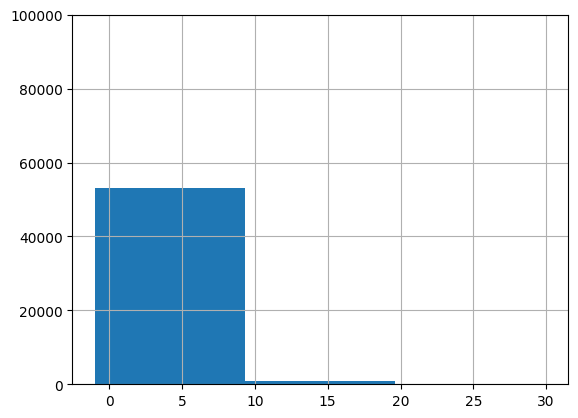

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# roi 컬럼에서 NaN과 inf 제거
df = df[df['roi'] < 30]

# 히스토그램 그리기
df['roi'].hist(bins=3)
plt.ylim(0, 100000)
plt.show()
